In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
HOG="Oct20_N1.tsv" ##othofinder output file
barley_del="barley_sum_deletion_V2.txt" ## barley gene matrix output
wheat_del="deletion_lowerCS_count.txt" ## wheat gene matrix output
emmer_del="domesticated_emmer_count_gene_deletion_list.txt" ## wild emmer CNV output

In [3]:
HF=pd.read_csv(HOG,header=0,sep="\t")

In [4]:
HF.head()

,HOG,OG,Gene Tree Parent Clade,Bdistachyon_pep,EM_A_pep,EM_B_pep,TaCS_A_pep_longest,TaCS_B_pep_longest,TaCS_D_pep_longest,barley
0,N1.HOG0000000,OG0000000,n27,NaN,NaN,TRIDC6BG006600.1,TraesCS6A02G038600,TraesCS6B02G053500,TraesCS2D02G316700,HORVU.MOREX.r2.6HG0453070.1
1,N1.HOG0000001,OG0000000,n31,NaN,NaN,NaN,TraesCS6A02G038400,TraesCS6B02G053300,NaN,HORVU.MOREX.r2.6HG0453060.1
2,N1.HOG0000002,OG0000000,n33,NaN,NaN,NaN,TraesCS7A02G158300,NaN,TraesCS6D02G044300,NaN
3,N1.HOG0000003,OG0000000,n34,NaN,NaN,NaN,TraesCS7A02G067800,TraesCS7B02G063000,TraesCS7D02G432000,NaN
4,N1.HOG0000004,OG0000000,n36,NaN,NaN,NaN,NaN,TraesCS7B02G062700,TraesCS7D02G061500,NaN


## merge A B D subgenome gene ids

In [5]:
HF['emmer'] = HF[HF.columns[4:6]].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)
HF['wheat'] = HF[HF.columns[6:9]].apply(lambda x: ', '.join(x.dropna().astype(str)), axis=1)

In [6]:
HF.head()

,HOG,OG,Gene Tree Parent Clade,Bdistachyon_pep,EM_A_pep,EM_B_pep,TaCS_A_pep_longest,TaCS_B_pep_longest,TaCS_D_pep_longest,barley,emmer,wheat
0,N1.HOG0000000,OG0000000,n27,NaN,NaN,TRIDC6BG006600.1,TraesCS6A02G038600,TraesCS6B02G053500,TraesCS2D02G316700,HORVU.MOREX.r2.6HG0453070.1,TRIDC6BG006600.1,"TraesCS6A02G038600, TraesCS6B02G053500, TraesC..."
1,N1.HOG0000001,OG0000000,n31,NaN,NaN,NaN,TraesCS6A02G038400,TraesCS6B02G053300,NaN,HORVU.MOREX.r2.6HG0453060.1,,"TraesCS6A02G038400, TraesCS6B02G053300"
2,N1.HOG0000002,OG0000000,n33,NaN,NaN,NaN,TraesCS7A02G158300,NaN,TraesCS6D02G044300,NaN,,"TraesCS7A02G158300, TraesCS6D02G044300"
3,N1.HOG0000003,OG0000000,n34,NaN,NaN,NaN,TraesCS7A02G067800,TraesCS7B02G063000,TraesCS7D02G432000,NaN,,"TraesCS7A02G067800, TraesCS7B02G063000, TraesC..."
4,N1.HOG0000004,OG0000000,n36,NaN,NaN,NaN,NaN,TraesCS7B02G062700,TraesCS7D02G061500,NaN,,"TraesCS7B02G062700, TraesCS7D02G061500"


## Rate calculation

In [7]:
bf=pd.read_csv(barley_del,header=None,delim_whitespace=True)
wf=pd.read_csv(wheat_del,header=None,delim_whitespace=True)
ef=pd.read_csv(emmer_del,header=None,delim_whitespace=True)

In [8]:
bf.head()

,0,1,2
0,HORVU.MOREX.r2.1HG0000020.1,1,Horvu_MOREX_1H01G000100.1
1,HORVU.MOREX.r2.1HG0000090.1,1,Horvu_MOREX_1H01G000800.1
2,HORVU.MOREX.r2.1HG0000180.1,7,Horvu_MOREX_1H01G001300.1
3,HORVU.MOREX.r2.1HG0000190.1,11,Horvu_MOREX_1H01G001400.1
4,HORVU.MOREX.r2.1HG0000200.1,1,Horvu_MOREX_1H01G001700.1


In [9]:
bf.set_index(0,inplace=True)

In [10]:
bf.head()

,1,2
0,,
HORVU.MOREX.r2.1HG0000020.1,1,Horvu_MOREX_1H01G000100.1
HORVU.MOREX.r2.1HG0000090.1,1,Horvu_MOREX_1H01G000800.1
HORVU.MOREX.r2.1HG0000180.1,7,Horvu_MOREX_1H01G001300.1
HORVU.MOREX.r2.1HG0000190.1,11,Horvu_MOREX_1H01G001400.1
HORVU.MOREX.r2.1HG0000200.1,1,Horvu_MOREX_1H01G001700.1


## This retention rate calculation only considers genes with pan-genome deletion, other genes were ignored. While this method may fail to account for strictly conserved gene, it is actually better for the purpose of identifying target genes with varying retention rates. 

## Because each HOG cell may contain both strictly conserved gene and deletion genes, by ignoring the strictly conserved gene, the final retention rate may better reflect the conservation level. Particularly, tetra/hexa ploid emmer and wheat, each HOG cell may contain 2 or 3 strictly conserved gene. If including the strictly conserved gene during retention rate calculation, the final retention rate results, emmer and wheat will be biased for a higher rates due to their higher ploidy level.

## For kaks calculation, instead of calculaiton for all pan_gene_matric lines, a compromised/smart way is to focus those HOGs with retention rate (ie containing deletion genes), then divide into strictly conserved and deletion genes, thus largely reduce the number of gene pairs for calculation (exceeding file limit in server).

In [11]:
###barley
HOG_id_list=[]
barley_rates=[]
j=0
c=0
d=0
e=0
f=0
for index, row in HF.iterrows(): # iteritems may not consider empty value;
    j+=1
    HOG_id_list.append(str(row["barley"]).split(", "))

for item in HOG_id_list:
    ####get occurence number for each gene in present in HOG groups, put in a list: generate
    generate=[]
    if item==["nan"]:
        c+=1
    else:
        d+=1
        for i in item: # loop over barley genes
            if i in bf.index: # get pan gene occurence number, if available, some gene may not
                generate+=[int(bf.loc[i,1])]
    
    ## calculate gene retention rate for each HOG group
    if generate==[]:
        e+=1
        rate=""
    else:
        f+=1
        rate=sum([x for x in generate])/len(generate)
        rate=1-rate/19
    
    ## add rate for each HOG to list
    barley_rates.append(rate)

In [12]:
wf.head()

,0,1
0,TraesCS1A02G000100,9
1,TraesCS1A02G000200,10
2,TraesCS1A02G000300,5
3,TraesCS1A02G000400,13
4,TraesCS1A02G000500,8


In [13]:
## Wheat get_homologue-est results contain alternative transcripts, use the transcript with the highest count

In [14]:
grouped_wf = wf.groupby(0)
maximums = grouped_wf.max()
maximums.head()

,1
0,
TraesCS1A02G000100,9
TraesCS1A02G000200,10
TraesCS1A02G000300,5
TraesCS1A02G000400,13
TraesCS1A02G000500,8


In [15]:
wf = maximums

In [16]:
###wheat
HOG_id_list=[]
wheat_rates=[]
j=0
c=0
d=0
e=0
f=0
for index, row in HF.iterrows(): # iteritems may not consider empty value;
    j+=1
    HOG_id_list.append(str(row["wheat"]).split(", "))

for item in HOG_id_list:
    ####get occurence number for each gene in present in HOG groups, put in a list: generate
    generate=[]
    if item==["nan"]:
        c+=1
    else:
        d+=1
        for i in item: # loop over barley genes
            #wid = i.split(".")[0] # old gene id containing "cds"
            wid = i
            if wid in wf.index: # get pan gene occurence number, if available, some gene may not
                generate+=[int(wf.loc[wid,1])]
    
    ## calculate gene retention rate for each HOG group
    if generate==[]:
        e+=1
        rate=""
    else:
        f+=1
        rate=sum([x for x in generate])/len(generate)
        rate=1-rate/15
    
    ## add rate for each HOG to list
    wheat_rates.append(rate)

In [17]:
ef.head()

,0,1
0,TRIDC0UG000030,4
1,TRIDC0UG000240,17
2,TRIDC0UG000270,9
3,TRIDC0UG000280,13
4,TRIDC0UG000290,3


In [18]:
ef.set_index(0,inplace=True)

In [19]:
###emmer
HOG_id_list=[]
emmer_rates=[]
j=0
c=0
d=0
e=0
f=0
for index, row in HF.iterrows(): # iteritems may not consider empty value;
    j+=1
    HOG_id_list.append(str(row["emmer"]).split(", "))

for item in HOG_id_list:
    ####get occurence number for each gene in present in HOG groups, put in a list: generate
    generate=[]
    if item==["nan"]:
        c+=1
    else:
        d+=1
        for i in item: # loop over barley genes
            eid = i.split(".")[0]
            if eid in ef.index: # get pan gene occurence number, if available, some gene may not
                generate+=[int(ef.loc[eid,1])]
    
    ## calculate gene retention rate for each HOG group
    if generate==[]:
        e+=1
        rate=""
    else:
        f+=1
        rate=sum([x for x in generate])/len(generate)
        rate=1-rate/20
    
    ## add rate for each HOG to list
    emmer_rates.append(rate)

In [20]:
HF["barley_rates"]=barley_rates
HF["wheat_rates"]=wheat_rates
HF["emmer_rates"]=emmer_rates

In [21]:
HF.head()

,HOG,OG,Gene Tree Parent Clade,Bdistachyon_pep,EM_A_pep,EM_B_pep,TaCS_A_pep_longest,TaCS_B_pep_longest,TaCS_D_pep_longest,barley,emmer,wheat,barley_rates,wheat_rates,emmer_rates
0,N1.HOG0000000,OG0000000,n27,NaN,NaN,TRIDC6BG006600.1,TraesCS6A02G038600,TraesCS6B02G053500,TraesCS2D02G316700,HORVU.MOREX.r2.6HG0453070.1,TRIDC6BG006600.1,"TraesCS6A02G038600, TraesCS6B02G053500, TraesC...",,0.866667,
1,N1.HOG0000001,OG0000000,n31,NaN,NaN,NaN,TraesCS6A02G038400,TraesCS6B02G053300,NaN,HORVU.MOREX.r2.6HG0453060.1,,"TraesCS6A02G038400, TraesCS6B02G053300",,,
2,N1.HOG0000002,OG0000000,n33,NaN,NaN,NaN,TraesCS7A02G158300,NaN,TraesCS6D02G044300,NaN,,"TraesCS7A02G158300, TraesCS6D02G044300",,,
3,N1.HOG0000003,OG0000000,n34,NaN,NaN,NaN,TraesCS7A02G067800,TraesCS7B02G063000,TraesCS7D02G432000,NaN,,"TraesCS7A02G067800, TraesCS7B02G063000, TraesC...",,,
4,N1.HOG0000004,OG0000000,n36,NaN,NaN,NaN,NaN,TraesCS7B02G062700,TraesCS7D02G061500,NaN,,"TraesCS7B02G062700, TraesCS7D02G061500",,,


In [22]:
HF.columns

Index(['HOG', 'OG', 'Gene Tree Parent Clade', 'Bdistachyon_pep', 'EM_A_pep',
       'EM_B_pep', 'TaCS_A_pep_longest', 'TaCS_B_pep_longest',
       'TaCS_D_pep_longest', 'barley', 'emmer', 'wheat', 'barley_rates',
       'wheat_rates', 'emmer_rates'],
      dtype='object')

In [23]:
## Fill empty cell with nan
HF = HF.replace(r'^\s*$', np.nan, regex=True)

In [24]:
## save file, for Figure 4C, move to "Figure6A_plotting_revised.ipynb" for further analyses

#HF.to_csv("/Volumes/Elements5T/Programs/gene_duplication_type/retention_rate_calculation_brett_wheat_deletion_lowerCS.csv",index=False)
HF.to_csv("retention_rate_calculation_wheatV2.csv",index=False)

In [24]:
df_barley=HF[HF["barley_rates"].notnull()]

In [25]:
df_barley.head()

,HOG,OG,Gene Tree Parent Clade,Bdistachyon_pep,EM_A_pep,EM_B_pep,TaCS_A_pep_longest,TaCS_B_pep_longest,TaCS_D_pep_longest,barley,emmer,wheat,barley_rates,wheat_rates,emmer_rates
28,N1.HOG0000028,OG0000001,n0,NaN,NaN,TRIDC5BG044300.1,NaN,NaN,NaN,"HORVU.MOREX.r2.6HG0490200.1, HORVU.MOREX.r2.7H...",TRIDC5BG044300.1,NaN,0.691729,NaN,NaN
30,N1.HOG0000030,OG0000002,n6,NaN,NaN,NaN,NaN,NaN,TraesCS6D02G029800,HORVU.MOREX.r2.5HG0446590.1,NaN,TraesCS6D02G029800,0.421053,0.400000,NaN
32,N1.HOG0000032,OG0000002,n10,NaN,TRIDC4AG026920.1,NaN,"TraesCS1A02G332100, TraesCS4A02G064100, TraesC...","TraesCS2B02G319900, TraesCS1B02G127100, TraesC...","TraesCS7D02G442000, TraesCS3D02G507200, TraesC...","HORVU.MOREX.r2.3HG0196890.1, HORVU.MOREX.r2.2H...",TRIDC4AG026920.1,"TraesCS1A02G332100, TraesCS4A02G064100, TraesC...",0.500000,0.419048,0.9
33,N1.HOG0000033,OG0000002,n46,NaN,NaN,NaN,NaN,"TraesCS4B02G232600, TraesCS6B02G319300",NaN,HORVU.MOREX.r2.3HG0257070.1,NaN,"TraesCS4B02G232600, TraesCS6B02G319300",0.947368,0.800000,NaN
34,N1.HOG0000034,OG0000002,n50,NaN,NaN,NaN,TraesCS1A02G140000,TraesCS5B02G179400,NaN,HORVU.MOREX.r2.5HG0446830.1,NaN,"TraesCS1A02G140000, TraesCS5B02G179400",0.631579,0.466667,NaN


In [26]:
df_barley.shape

(3995, 15)

## More stringent target gene filtration i.e retention rates fold change > 1.2

In [30]:
from Bio import SeqIO
barleyV2 = "/Volumes/Elements5T/Programs/enrichment_GO/blastp_match/barley.fasta"

In [30]:
## export all df_barley barley gene id for enrichment references
id_list = []
for index, row in df_barley.iterrows():
    id_list +=row["barley"].split(", ")

with open("df_barley_barleyIDs.fasta", "w") as f,\
 open ("df_barley_barleyIDs.txt", "w") as f2:
    for rec in SeqIO.parse(barleyV2,"fasta"):
        if rec.id in id_list:
            f2.write(rec.id+'\n')
            SeqIO.write(rec,f,"fasta")

## target gene selection for enrichment analyses

In [27]:
df_barley["barley/emmer"]=df_barley["barley_rates"]/df_barley["emmer_rates"]
df_barley["barley/wheat"]=df_barley["barley_rates"]/df_barley["wheat_rates"]
df_barley["emmer/wheat"]=df_barley["emmer_rates"]/df_barley["wheat_rates"]

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [32]:
## save file df_barley.csv used for Figure6A plotting
#df_barley.to_csv("/Users/yongjia/Dropbox/HPY/Submission/enrichment_plot/df_barley.csv",index=False)
df_barley.to_csv("df_barley.csv",index=False)

In [28]:
## results are good, but not that significant
df_test3 = df_barley[(df_barley["emmer/wheat"]>=1.01) & (df_barley["barley/emmer"]>=1.01)]
df_test3.shape
#df_test3.drop("OG_barley_gene_concat").to_csv("/Volumes/Elements5T/Programs/enrichment_GO/Brettwheat/selected_gene_function_analyses/df_test3.csv")


(314, 18)

In [29]:
df_test3.to_csv("df_test3_wheatV2.csv",index=False)

In [46]:
id_list = []
for index, row in df_test3.iterrows():
    id_list +=row["barley"].split(", ")

with open("target_gene_wheatV2_test3.fasta", "w") as f, open("target_gene_wheatV2_test3.txt","w") as f2:
    for rec in SeqIO.parse(barleyV2,"fasta"):
        if rec.id in id_list:
            f2.write('%s\n' % rec.id)
            SeqIO.write(rec,f,"fasta")

## barley and wheat rates comparison

In [28]:
## refer above for df_target, which counts wheat_rates as well
Group1 = df_barley[df_barley["barley/wheat"]>1.2]
Group2 = df_barley[(df_barley["barley/wheat"]<1.1) & (df_barley["barley/wheat"]>0.9)]
Group3 = df_barley[df_barley["barley/wheat"]<0.8]

In [31]:
id_list = []
for index, row in Group1.iterrows():
    id_list +=row["barley"].split(", ")

with open("Group1_wheatV2.fasta", "w") as f, open("Group1_wheatV2.txt","w") as f2:
    for rec in SeqIO.parse(barleyV2,"fasta"):
        if rec.id in id_list:
            f2.write('%s\n' % rec.id)
            SeqIO.write(rec,f,"fasta")

In [32]:
id_list = []
for index, row in Group2.iterrows():
    id_list +=row["barley"].split(", ")

with open("Group2_wheatV2.fasta", "w") as f, open("Group2_wheatV2.txt","w") as f2:
    for rec in SeqIO.parse(barleyV2,"fasta"):
        if rec.id in id_list:
            f2.write('%s\n' % rec.id)
            SeqIO.write(rec,f,"fasta")

In [33]:
id_list = []
for index, row in Group3.iterrows():
    id_list +=row["barley"].split(", ")

with open("Group3_wheatV2.fasta", "w") as f, open("Group3_wheatV2.txt","w") as f2:
    for rec in SeqIO.parse(barleyV2,"fasta"):
        if rec.id in id_list:
            f2.write('%s\n' % rec.id)
            SeqIO.write(rec,f,"fasta")

## use the above data and retrieve gene duplication type, and plot figure 6B in Figure6A_plotting_revised.ipynb

In [ ]:
go to Figure6A_plotting_revised.ipynb

### test using a single representative sequence for each HOG

In [127]:
target_id_list = []
non_target_id_list=[]
non_target4_id_list=[]
# df_target3 = df_barley[df_barley["barley/emmer"]>=1.2]
# df_non_target3 = df_barley[df_barley["barley/emmer"]<=0.8]
df_non_target4 = df_barley[(df_barley["barley/emmer"]>0.8) & (df_barley["barley/emmer"]<1.2)]

# for index, row in df_target3.iterrows():
#     target_id_list.append(row["barley"].split(", ")[0])
    
# for index, row in df_non_target3.iterrows():
#     non_target_id_list.append(row["barley"].split(", ")[0])
for index, row in df_non_target4.iterrows():
    non_target4_id_list += row["barley"].split(", ")

# with open("/Volumes/Elements5T/Programs/enrichment_GO/blastp_match/OctN1_barley_target3_test_id.txt", "w") as f:
#     for item in target_id_list:
#         f.write(str(item)+"\n")

# with open("/Volumes/Elements5T/Programs/enrichment_GO/blastp_match/OctN1_barley_non_target3_test_id.txt", "w") as f:
#     for item in non_target_id_list:
#         f.write(str(item)+"\n")

with open("/Volumes/Elements5T/Programs/enrichment_GO/blastp_match/OctN1_barley_non_target44_test_id.txt", "w") as f:
    for item in non_target4_id_list:
        f.write(str(item)+"\n")

## Extract target barley gene IDs for downstream analyses

In [32]:
id_list = []
for index, row in df_target.iterrows():
    id_list +=row["barley"].split(", ")

with open("OctN1_barley_target_id.txt", "w") as f:
    for item in id_list:
        f.write(str(item)+"\n")

In [166]:
id_list = []
with open("/Volumes/Elements5T/pan_gene_count_wheatbarleyemmer/barley/OctN1_barleyHOG_with_retention_rate_all_id.txt", "w") as f:
    f.write("HOG" + '\t' + "OG" + '\t' + "barleyV2ID" + '\t' + "OG_barley_gene_num" + "\n")
    for index, row in df_barley.iterrows():
        id_list = row["barley"].split(", ")
        for item in id_list:
            f.write(row["HOG"] + '\t' + row["OG"] + '\t' + str(item) + '\t' + str(row["OG_barley_gene_num"]) + "\n")
            

In [167]:
df_barley["OG_barley_gene_num"].sum()

13473

# Generate gene pairs for kaks calculation

### For target test3 genes, get OG list, retrieve all HOGs for these OGs, including HOGs not present in target, calculate kaks for each HOGs, compare those HOGs present in target with those not

In [29]:
from itertools import combinations

In [30]:
df_test3.head()

,HOG,OG,Gene Tree Parent Clade,Bdistachyon_pep,EM_A_pep,EM_B_pep,TaCS_A_pep_longest,TaCS_B_pep_longest,TaCS_D_pep_longest,barley,emmer,wheat,barley_rates,wheat_rates,emmer_rates,barley/emmer,barley/wheat,emmer/wheat
102,N1.HOG0000102,OG0000006,n36,NaN,"TRIDC6AG012020.1, TRIDC1AG054270.1, TRIDC1AG05...","TRIDC6BG017380.1, TRIDC1BG062120.1",TraesCS6A02G094200,"TraesCS6B02G122600, TraesCS1B02G388200, TraesC...","TraesCS1D02G375100, TraesCS1D02G374900, TraesC...","HORVU.MOREX.r2.1HG0073480.1, HORVU.MOREX.r2.1H...","TRIDC6AG012020.1, TRIDC1AG054270.1, TRIDC1AG05...","TraesCS6A02G094200, TraesCS6B02G122600, TraesC...",0.947368,0.600000,0.71250,1.329640,1.578947,1.187500
255,N1.HOG0000255,OG0000025,n39,NaN,NaN,TRIDC6BG003200.1,TraesCS6A02G021800,NaN,NaN,"HORVU.MOREX.r2.6HG0450550.1, HORVU.MOREX.r2.6H...",TRIDC6BG003200.1,TraesCS6A02G021800,0.894737,0.733333,0.85000,1.052632,1.220096,1.159091
275,N1.HOG0000275,OG0000027,n10,NaN,TRIDC3AG061550.1,TRIDC3BG083090.1,"TraesCS4A02G483600, TraesCS3A02G435200",TraesCS3B02G575400,NaN,HORVU.MOREX.r2.7HG0528980.1,"TRIDC3AG061550.1, TRIDC3BG083090.1","TraesCS4A02G483600, TraesCS3A02G435200, TraesC...",0.894737,0.133333,0.85000,1.052632,6.710526,6.375000
286,N1.HOG0000286,OG0000027,n65,NaN,TRIDC2AG071110.1,TRIDC2BG076950.1,TraesCS2A02G505200,TraesCS2B02G533400,TraesCS2D02G505900,HORVU.MOREX.r2.2HG0168960.1,"TRIDC2AG071110.1, TRIDC2BG076950.1","TraesCS2A02G505200, TraesCS2B02G533400, TraesC...",0.947368,0.066667,0.85000,1.114551,14.210526,12.750000
313,N1.HOG0000313,OG0000032,n19,NaN,"TRIDC7AG060800.1, TRIDC6AG012470.1, TRIDC6AG01...","TRIDC7BG053840.1, TRIDC6BG017660.1, TRIDC5BG06...","TraesCS6A02G096700, TraesCS7A02G437300, TraesC...","TraesCS7B02G336300, TraesCS6B02G125200, TraesC...","TraesCS7D02G427200, TraesCS6D02G087800, TraesC...",HORVU.MOREX.r2.1HG0008270.1,"TRIDC7AG060800.1, TRIDC6AG012470.1, TRIDC6AG01...","TraesCS6A02G096700, TraesCS7A02G437300, TraesC...",0.947368,0.633333,0.71875,1.318078,1.495845,1.134868


In [31]:
target_OGs = list(df_test3["OG"].unique())

In [32]:
len(target_OGs)

303

In [33]:
df_target = df_barley[df_barley["OG"].isin(target_OGs)]

In [34]:
df_barley.shape

(3995, 18)

In [35]:
df_target.shape

(434, 18)

In [76]:
## generate gene ID pairs for each HOG group
##get the barley ID with decreasing retention rates across three species
HOG_gene_pair_list = []
with open("barley_wheat_emmer_inter_pairs.txt","w") as f:
    for index, row in df_target.iterrows():
        row_list=str(row["barley"]).split(", ") + str(row["wheat"]).split(", ") + str(row["emmer"]).split(", ")

        row_list = [x for x in row_list if x!="nan"] ##remove "nan"
        res = list(combinations(row_list, 2))
        for tp in res:
                if tp[0][:4] != tp[1][:4]: ## only inter gene pairs
                    f.write(row["HOG"]+'-'+row["OG"]+'-'+'-'.join(list(tp))+'\n')La 

In [66]:
df_target.to_csv("df_target.csv",index=False)

In [70]:
## generate gene, HOG, OG IDs matches
HOG_gene_pair_list = []
with open("df_target_gene_HOG_OG.txt","w") as f:
    for index, row in df_target.iterrows():
        row_list=str(row["barley"]).split(", ") + str(row["wheat"]).split(", ") + str(row["emmer"]).split(", ")

        row_list = [x for x in row_list if x!="nan"] ##remove "nan"
        for gene in row_list:
                f.write(row["HOG"]+'\t'+row["OG"]+'\t'+gene+'\n')

In [165]:
## generate gene ID pairs for each HOG group
##get the barley ID with decreasing retention rates across three species
HOG_gene_pair_list = []
with open("/Volumes/Elements5T/pan_gene_count_wheatbarleyemmer/kaks_calculation/Oct20_HOG_gene_pairs_barley_rates_notna_inter.txt","w") as f:
    for index, row in HF[HF.barley_rates.notna()].iterrows():
        row_list=str(row["barley"]).split(", ") + str(row["wheat"]).split(", ") + str(row["emmer"]).split(", ")

        row_list = [x for x in row_list if x!="nan"] ##remove "nan"
        res = list(combinations(row_list, 2))
        for tp in res:
                if tp[0][:4] != tp[1][:4]:
                    f.write(row["HOG"]+'-'+row["OG"]+'-'+'-'.join(list(tp))+'\n')

## Merge with kaks results

In [167]:
## read kaks files
kaks_emmer="/Volumes/Elements5T/pan_gene_count_wheatbarleyemmer/kaks_calculation/Oct20_HOG_gene_pairs_barley_emmer_inter_updated.kaks"
kaks_wheat="/Volumes/Elements5T/pan_gene_count_wheatbarleyemmer/kaks_calculation/Oct20_HOG_gene_pairs_barley_wheat_inter.kaks"

In [168]:
KAKSemmer=pd.read_csv(kaks_emmer,header=0,delim_whitespace=True)
KAKSwheat=pd.read_csv(kaks_wheat,header=0,delim_whitespace=True)

In [174]:
KAKSemmer.tail()

,Sequence,Method,Ka,Ks,Ka/Ks,P-Value(Fisher),Length,S-Sites,N-Sites,Fold-Sites(0:2:4),...,N-Substitutions,Fold-S-Substitutions(0:2:4),Fold-N-Substitutions(0:2:4),Divergence-Time,Substitution-Rate-Ratio(rTC:rAG:rTA:rCG:rTG:rCA/rCA),GC(1:2:3),ML-Score,AICc,Akaike-Weight,Model
50021,HORVU.MOREX.r2.7HG0608610-TRIDC2BG076790,MA,0.171548,0.880330,0.194868,1.815820e-09,159,36.5744,122.426,NaN,...,14.606700,NaN,NaN,0.334588,1.40538:0.825442:0.928895:0.911317:0.858192:1,0.418239(0.396226:0.518868:0.339623),-325.346,NaN,NaN,NaN
50022,HORVU.MOREX.r2.7HG0534080-TRIDC1AG063240,MA,0.166719,0.196293,0.849338,3.099510e-01,1104,326.1480,777.852,NaN,...,111.136000,NaN,NaN,0.175456,4.45121:2.55884:1.52545:1.53379:1.07343:1,0.504529(0.523098:0.486413:0.504076),-2072.030,NaN,NaN,NaN
50023,HORVU.MOREX.r2.6HG0468020-TRIDC6AG017840,MA,0.026035,0.089552,0.290723,2.391470e-04,759,207.9280,551.072,NaN,...,13.490900,NaN,NaN,0.043436,1.55608:1.9226:1.12846:1.13683:0.366464:1,0.497365(0.555336:0.448617:0.488142),-1179.800,NaN,NaN,NaN
50024,HORVU.MOREX.r2.7HG0622800-TRIDC7BG074430,MA,0.201322,0.424303,0.474478,1.692260e-15,1872,459.9020,1412.100,NaN,...,227.702000,NaN,NaN,0.256103,1.97878:2.00095:1.62899:1.7576:0.762033:1,0.444979(0.514423:0.38141:0.439103),-3815.390,NaN,NaN,NaN
50025,HORVU.MOREX.r2.5HG0364190-TRIDC5BG013060,MA,0.011757,0.413237,0.028451,0.000000e+00,114,26.6410,87.359,NaN,...,0.682666,NaN,NaN,0.105580,10.1744:1.69886:0.746605:0.746605:0.436803:1,0.614035(0.486842:0.5:0.855263),-166.631,NaN,NaN,NaN


In [170]:
## read barley-emmer gene pairs and HOG IDs
pairs_emmer = "/Volumes/Elements5T/pan_gene_count_wheatbarleyemmer/kaks_calculation/Oct20_HOG_gene_pairs_barley_emmer_inter.txt"
PAIRSemmer=pd.read_csv(pairs_emmer,header=None,sep="-")

In [196]:
## merge with emmer kaks
PAIRSemmer[4] = PAIRSemmer[2].str.slice(0,25) + "-" + PAIRSemmer[3].str.split(".",expand=True)[0]

In [205]:
PAIRSemmer = PAIRSemmer.merge(KAKSemmer,left_on=4,right_on="Sequence",how="inner")

In [216]:
## read barley-emmer gene pairs and HOG IDs
pairs_wheat = "/Volumes/Elements5T/pan_gene_count_wheatbarleyemmer/kaks_calculation/Oct20_HOG_gene_pairs_barley_wheat_inter.txt"
PAIRSwheat=pd.read_csv(pairs_wheat,header=None,sep="-")
PAIRSwheat[4] = PAIRSwheat[2].str.slice(0,25) + "-" + PAIRSwheat[3]

In [221]:
## merge with wheat kaks
PAIRSwheat = PAIRSwheat.merge(KAKSwheat,left_on=4,right_on="Sequence",how="inner")

In [224]:
PAIRSemmer.head()

,0,1,2,3,4,Sequence,Method,Ka,Ks,Ka/Ks,...,N-Substitutions,Fold-S-Substitutions(0:2:4),Fold-N-Substitutions(0:2:4),Divergence-Time,Substitution-Rate-Ratio(rTC:rAG:rTA:rCG:rTG:rCA/rCA),GC(1:2:3),ML-Score,AICc,Akaike-Weight,Model
0,N1.HOG0000000,OG0000000,HORVU.MOREX.r2.6HG0453070.1,TRIDC6BG006600.1,HORVU.MOREX.r2.6HG0453070-TRIDC6BG006600,HORVU.MOREX.r2.6HG0453070-TRIDC6BG006600,MA,0.001703,1.489900,0.001143,...,0.358982,NaN,NaN,0.105913,0.708391:0.393107:7.87832:0.305592:4.08745:1,0.672886(0.645522:0.470149:0.902985),-572.536,NaN,NaN,NaN
1,N1.HOG0000007,OG0000000,HORVU.MOREX.r2.7HG0535370.1,TRIDC7BG009250.1,HORVU.MOREX.r2.7HG0535370-TRIDC7BG009250,HORVU.MOREX.r2.7HG0535370-TRIDC7BG009250,MA,0.007413,3.098110,0.002393,...,1.381520,NaN,NaN,0.191743,2.22939:0.730247:8.08985:0.887698:3.67548:1,0.689951(0.625:0.470588:0.974265),-557.821,NaN,NaN,NaN
2,N1.HOG0000007,OG0000000,HORVU.MOREX.r2.7HG0535380.1,TRIDC7BG009250.1,HORVU.MOREX.r2.7HG0535380-TRIDC7BG009250,HORVU.MOREX.r2.7HG0535380-TRIDC7BG009250,MA,0.005608,1.454880,0.003855,...,1.146640,NaN,NaN,0.137783,3.23995:1.13478:2.42351:1.16689:3.48843:1,0.692402(0.632353:0.470588:0.974265),-551.659,NaN,NaN,NaN
3,N1.HOG0000007,OG0000000,HORVU.MOREX.r2.7HG0548720.1,TRIDC7BG009250.1,HORVU.MOREX.r2.7HG0548720-TRIDC7BG009250,HORVU.MOREX.r2.7HG0548720-TRIDC7BG009250,MA,0.000691,0.691005,0.001000,...,0.104232,NaN,NaN,0.101845,20.202:10.2659:18.5564:18.5904:0.01:1,0.697304(0.639706:0.470588:0.981618),-523.895,NaN,NaN,NaN
4,N1.HOG0000007,OG0000000,HORVU.MOREX.r2.2HG0142360.1,TRIDC7BG009250.1,HORVU.MOREX.r2.2HG0142360-TRIDC7BG009250,HORVU.MOREX.r2.2HG0142360-TRIDC7BG009250,MA,0.004624,4.624400,0.001000,...,0.379997,NaN,NaN,0.762905,0.397389:0.0480269:0.182688:0.203083:0.77741:1,0.636029(0.621324:0.470588:0.816176),-637.869,NaN,NaN,NaN


In [422]:
## Filter 1:  only use Ka/Ks <=10
PAIRSemmer = PAIRSemmer[ PAIRSemmer["Ka/Ks"] <=10]
PAIRSwheat = PAIRSwheat[ PAIRSwheat["Ka/Ks"] <=10]

In [502]:
## Filter 2: only use gene with deletions

# read barley deletion gene info
df_del = pd.read_csv("barley_sum_deletion_V2.txt",header=None, sep="\t")
df_del.columns = ["V2_del","del_num","pan_ID"]
df_del = df_del[["V2_del"]]
df_del.head()

,V2_del
0,HORVU.MOREX.r2.1HG0000020.1
1,HORVU.MOREX.r2.1HG0000090.1
2,HORVU.MOREX.r2.1HG0000180.1
3,HORVU.MOREX.r2.1HG0000190.1
4,HORVU.MOREX.r2.1HG0000200.1


In [503]:
PAIRSemmer = PAIRSemmer.merge(df_del,left_on=2,right_on="V2_del",how="inner")
PAIRSwheat = PAIRSwheat.merge(df_del,left_on=2,right_on="V2_del",how="inner")

In [506]:
PAIRSemmer.shape

(6797, 28)

In [507]:
PAIRSemmer_grouped = PAIRSemmer.groupby([0,1]).mean()
PAIRSwheat_grouped = PAIRSwheat.groupby([0,1]).mean()

In [508]:
PAIRSemmer_grouped = PAIRSemmer_grouped.reset_index()
PAIRSwheat_grouped = PAIRSwheat_grouped.reset_index()

In [511]:
PAIRSemmer_grouped.head()

,0,1,Ka,Ks,Ka/Ks,P-Value(Fisher),Length,S-Sites,N-Sites,Fold-Sites(0:2:4),Substitutions,S-Substitutions,N-Substitutions,Fold-S-Substitutions(0:2:4),Fold-N-Substitutions(0:2:4),Divergence-Time,ML-Score,AICc,Akaike-Weight,Model
0,N1.HOG0000028,OG0000001,0.213713,3.412116,0.097309,1.382871e-02,144.214286,34.089764,110.12445,NaN,41.928571,33.550364,8.378201,NaN,NaN,0.967852,-298.168571,NaN,NaN,NaN
1,N1.HOG0000032,OG0000002,0.080522,0.379829,0.214795,4.778902e-08,541.500000,72.386600,469.11350,NaN,56.000000,23.485900,32.514100,NaN,NaN,0.120329,-910.479000,NaN,NaN,NaN
2,N1.HOG0000102,OG0000006,0.022102,0.918084,0.034209,3.067960e-24,796.200000,178.278600,617.92140,NaN,89.800000,81.978800,7.821118,NaN,NaN,0.218921,-1318.016000,NaN,NaN,NaN
3,N1.HOG0000103,OG0000006,0.019791,0.293054,0.067535,5.301070e-22,798.000000,188.022000,609.97800,NaN,54.000000,44.295200,9.704810,NaN,NaN,0.084177,-1258.510000,NaN,NaN,NaN
4,N1.HOG0000106,OG0000006,0.013280,0.245329,0.054130,9.525690e-20,798.000000,213.441000,584.55900,NaN,48.000000,41.802900,6.197140,NaN,NaN,0.075346,-1242.620000,NaN,NaN,NaN


In [512]:
PAIRSemmer_grouped = PAIRSemmer_grouped[PAIRSemmer_grouped.columns.to_list()[0:5]]
PAIRSwheat_grouped = PAIRSwheat_grouped[PAIRSwheat_grouped.columns.to_list()[0:5]]
PAIRSwheat_grouped.head()

,0,1,Ka,Ks,Ka/Ks
0,N1.HOG0000032,OG0000002,0.120116,0.550370,0.251672
1,N1.HOG0000038,OG0000002,0.091480,0.372117,0.253278
2,N1.HOG0000063,OG0000004,0.017779,1.181903,0.015275
3,N1.HOG0000102,OG0000006,0.024116,1.206656,0.028741
4,N1.HOG0000103,OG0000006,0.018930,0.286513,0.066038


In [513]:
cols1 = ["emmer_"+str(col) for col in PAIRSemmer_grouped.columns]
cols2 = ["wheat_"+str(col) for col in PAIRSwheat_grouped.columns]

In [514]:
PAIRSemmer_grouped[cols1] = PAIRSemmer_grouped

In [515]:
PAIRSwheat_grouped[cols2] = PAIRSwheat_grouped

In [516]:
PAIRSemmer_grouped = PAIRSemmer_grouped[PAIRSemmer_grouped.columns[5:]]

In [517]:
PAIRSwheat_grouped = PAIRSwheat_grouped[PAIRSwheat_grouped.columns[5:]]

In [518]:
PAIRSwheat_grouped.head()

,wheat_0,wheat_1,wheat_Ka,wheat_Ks,wheat_Ka/Ks
0,N1.HOG0000032,OG0000002,0.120116,0.550370,0.251672
1,N1.HOG0000038,OG0000002,0.091480,0.372117,0.253278
2,N1.HOG0000063,OG0000004,0.017779,1.181903,0.015275
3,N1.HOG0000102,OG0000006,0.024116,1.206656,0.028741
4,N1.HOG0000103,OG0000006,0.018930,0.286513,0.066038


In [519]:
df_barley.head()

,HOG,OG,Gene Tree Parent Clade,Bdistachyon_pep,EM_A_pep,EM_B_pep,TaCS_A_pep_longest,TaCS_B_pep_longest,TaCS_D_pep_longest,barley,...,wheat,barley_rates,wheat_rates,emmer_rates,OG_counts,OG_barley_gene_concat,OG_barley_gene_num,barley/emmer,barley/wheat,emmer/wheat
0,N1.HOG0000028,OG0000001,n0,NaN,NaN,TRIDC5BG044300.1,NaN,NaN,NaN,"HORVU.MOREX.r2.6HG0490200.1, HORVU.MOREX.r2.7H...",...,NaN,0.691729,NaN,NaN,1,"HORVU.MOREX.r2.6HG0490200.1, HORVU.MOREX.r2.7H...",167,NaN,NaN,NaN
1,N1.HOG0000030,OG0000002,n6,NaN,NaN,NaN,NaN,NaN,TraesCS6D02G029800,HORVU.MOREX.r2.5HG0446590.1,...,TraesCS6D02G029800,0.421053,NaN,NaN,10,"HORVU.MOREX.r2.5HG0393280.1, HORVU.MOREX.r2.5H...",13,NaN,NaN,NaN
2,N1.HOG0000032,OG0000002,n10,NaN,TRIDC4AG026920.1,NaN,"TraesCS1A02G332100, TraesCS4A02G064100, TraesC...","TraesCS2B02G319900, TraesCS1B02G127100, TraesC...","TraesCS7D02G442000, TraesCS3D02G507200, TraesC...","HORVU.MOREX.r2.3HG0196890.1, HORVU.MOREX.r2.2H...",...,"TraesCS1A02G332100, TraesCS4A02G064100, TraesC...",0.500000,0.590476,0.9,10,"HORVU.MOREX.r2.5HG0393280.1, HORVU.MOREX.r2.5H...",13,0.555556,0.846774,1.524194
3,N1.HOG0000033,OG0000002,n46,NaN,NaN,NaN,NaN,"TraesCS4B02G232600, TraesCS6B02G319300",NaN,HORVU.MOREX.r2.3HG0257070.1,...,"TraesCS4B02G232600, TraesCS6B02G319300",0.947368,NaN,NaN,10,"HORVU.MOREX.r2.5HG0393280.1, HORVU.MOREX.r2.5H...",13,NaN,NaN,NaN
4,N1.HOG0000034,OG0000002,n50,NaN,NaN,NaN,TraesCS1A02G140000,TraesCS5B02G179400,NaN,HORVU.MOREX.r2.5HG0446830.1,...,"TraesCS1A02G140000, TraesCS5B02G179400",0.631579,NaN,NaN,10,"HORVU.MOREX.r2.5HG0393280.1, HORVU.MOREX.r2.5H...",13,NaN,NaN,NaN


In [520]:
df_barley_kaks = df_barley.merge(PAIRSemmer_grouped,left_on="HOG",right_on="emmer_0",how="left")

In [521]:
df_barley_kaks = df_barley_kaks.merge(PAIRSwheat_grouped,left_on="HOG",right_on="wheat_0",how="left")

In [522]:
df_barley_kaks.columns

Index(['HOG', 'OG', 'Gene Tree Parent Clade', 'Bdistachyon_pep', 'EM_A_pep',
       'EM_B_pep', 'TaCS_A_pep_longest', 'TaCS_B_pep_longest',
       'TaCS_D_pep_longest', 'barley', 'emmer', 'wheat', 'barley_rates',
       'wheat_rates', 'emmer_rates', 'OG_counts', 'OG_barley_gene_concat',
       'OG_barley_gene_num', 'barley/emmer', 'barley/wheat', 'emmer/wheat',
       'emmer_0', 'emmer_1', 'emmer_Ka', 'emmer_Ks', 'emmer_Ka/Ks', 'wheat_0',
       'wheat_1', 'wheat_Ka', 'wheat_Ks', 'wheat_Ka/Ks'],
      dtype='object')

In [523]:
df_barley_test = df_barley_kaks[['HOG','OG',
                                'barley_rates','wheat_rates', 'emmer_rates',
                                 'OG_counts', 'OG_barley_gene_num',
                                'barley/emmer','barley/wheat', 'emmer/wheat',
                                'emmer_Ka', 'emmer_Ks', 'emmer_Ka/Ks',
                                'wheat_Ka', 'wheat_Ks', 'wheat_Ka/Ks']]

In [524]:
df_barley_test.head()

,HOG,OG,barley_rates,wheat_rates,emmer_rates,OG_counts,OG_barley_gene_num,barley/emmer,barley/wheat,emmer/wheat,emmer_Ka,emmer_Ks,emmer_Ka/Ks,wheat_Ka,wheat_Ks,wheat_Ka/Ks
0,N1.HOG0000028,OG0000001,0.691729,NaN,NaN,1,167,NaN,NaN,NaN,0.213713,3.412116,0.097309,NaN,NaN,NaN
1,N1.HOG0000030,OG0000002,0.421053,NaN,NaN,10,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,N1.HOG0000032,OG0000002,0.500000,0.590476,0.9,10,13,0.555556,0.846774,1.524194,0.080522,0.379829,0.214795,0.120116,0.55037,0.251672
3,N1.HOG0000033,OG0000002,0.947368,NaN,NaN,10,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,N1.HOG0000034,OG0000002,0.631579,NaN,NaN,10,13,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [525]:
## remove inf values
df_barley_test = df_barley_test.replace([np.inf, -np.inf], np.nan)

In [526]:
df_barley_test = df_barley_test[df_barley_test["wheat_rates"]>=0.1]

In [527]:
from scipy.stats import pearsonr

In [528]:
def corrfunc2(x, y, **kws):
    nas = np.logical_or(x.isna(), y.isna())
    (r, p) = pearsonr(x[~nas], y[~nas])
    ax = plt.gca()
    ax.annotate("r = {:.2f} \n".format(r),
                xy=(.1, .9), xycoords=ax.transAxes)
    ax.annotate("p = {:.2e}".format(p),
                xy=(.4, .9), xycoords=ax.transAxes)

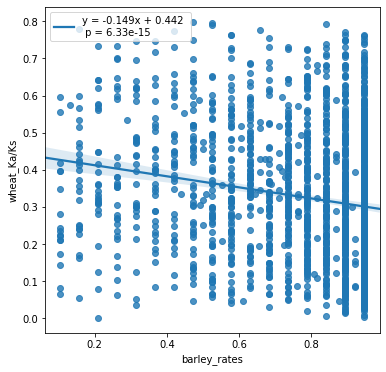

In [553]:
# Filtered = df_barley_test[(df_barley_test["emmer_Ka/Ks"] < 0.5)
#                           #& (df_barley_test2["barley/emmer"] < 7)
#                          ]
# fig,ax = plt.subplots(figsize=(6,6))
# slope, intercept, r_value, p_value, std_err = stats.linregress(Filtered["barley_rates"],Filtered["emmer_Ka/Ks"])
# sns.regplot(ax=ax, x="barley_rates", y="emmer_Ka/Ks",data=Filtered,\
#             line_kws={'label':"y = {0:.3f}x + {1:.3f} \n p = {2:.2e}".format(slope,intercept, p_value)})
# #ax1.set_ylim([0.2,1.1])
# ax.legend()
# plt.show()

Filtered = df_barley_test[(df_barley_test["wheat_Ka/Ks"] < 0.8)
                          #& (df_barley_test2["barley/emmer"] < 7)
                         ]
fig,ax = plt.subplots(figsize=(6,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(Filtered["barley_rates"],Filtered["wheat_Ka/Ks"])
sns.regplot(ax=ax, x="barley_rates", y="wheat_Ka/Ks",data=Filtered,\
            line_kws={'label':"y = {0:.3f}x + {1:.3f} \n p = {2:.2e}".format(slope,intercept, p_value)})
#ax1.set_ylim([0.2,1.1])
ax.legend()
plt.show()

In [554]:
r_value

-0.1813736096254938

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


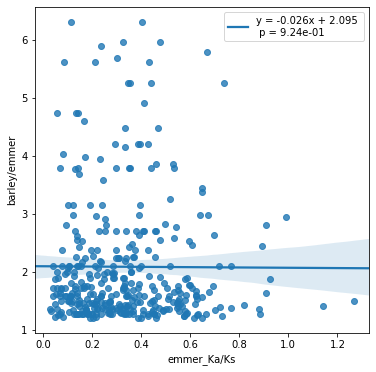

In [536]:
Filtered = df_barley_test[(df_barley_test["barley/emmer"] >= 1.2)
                          & (df_barley_test2["barley/emmer"] < 7)
                         ]
fig,ax = plt.subplots(figsize=(6,6))
slope, intercept, r_value, p_value, std_err = stats.linregress(Filtered["emmer_Ka/Ks"],Filtered["barley/emmer"])
sns.regplot(ax=ax, x="emmer_Ka/Ks",y="barley/emmer",data=Filtered,\
            line_kws={'label':"y = {0:.3f}x + {1:.3f} \n p = {2:.2e}".format(slope,intercept, p_value)})
#ax1.set_ylim([0.2,1.1])
ax.legend()
plt.show()

# Filtered = df_barley_test[(df_barley_test["barley/wheat"] >= 2)
#                           & (df_barley_test2["barley/wheat"] < 7)
#                          ]
# fig,ax = plt.subplots(figsize=(6,6))
# slope, intercept, r_value, p_value, std_err = stats.linregress(Filtered["wheat_Ka/Ks"],Filtered["barley/wheat"])
# sns.regplot(ax=ax, x="wheat_Ka/Ks",y="barley/wheat",data=Filtered,\
#             line_kws={'label':"y = {0:.3f}x + {1:.3f} \n p = {2:.2e}".format(slope,intercept, p_value)})
# #ax1.set_ylim([0.2,1.1])
# ax.legend()
# plt.show()

## OctN1, Count gene number for each OG group, for three species

In [27]:
HF2 = HF[["OG","barley"]].dropna()
HF2["OG_barley_gene_concat"]=HF2.groupby("OG")["barley"].transform(lambda x: ', '.join(x))
HF2["OG_barley_gene_num"]=HF2["OG_barley_gene_concat"].str.split(expand=False).str.len()
HF2 = HF2[["OG","OG_barley_gene_concat","OG_barley_gene_num"]].drop_duplicates()

HF4 = HF[["OG","emmer"]].dropna()
HF4["OG_emmer_gene_concat"]=HF4.groupby("OG")["emmer"].transform(lambda x: ', '.join(x))
HF4["OG_emmer_gene_num"]=HF4["OG_emmer_gene_concat"].str.split(expand=False).str.len()
HF4 = HF4[["OG","OG_emmer_gene_concat","OG_emmer_gene_num"]].drop_duplicates()

HF6 = HF[["OG","wheat"]].dropna()
HF6["OG_wheat_gene_concat"]=HF6.groupby("OG")["wheat"].transform(lambda x: ', '.join(x))
HF6["OG_wheat_gene_num"]=HF6["OG_wheat_gene_concat"].str.split(expand=False).str.len()
HF6 = HF6[["OG","OG_wheat_gene_concat","OG_wheat_gene_num"]].drop_duplicates()

In [28]:
df_barley=HF[HF["barley_rates"].notnull()]
df_emmer=HF[HF["emmer_rates"].notnull()]
df_wheat=HF[HF["wheat_rates"].notnull()]

## merge with OG gene number count data
df_barley = df_barley.merge(HF2,on="OG",how="left")
df_emmer = df_emmer.merge(HF4,on="OG",how="left")
df_wheat = df_wheat.merge(HF6,on="OG",how="left")

## get mean retention rate for each OG
df_barley_tem = df_barley[["OG","barley_rates","OG_barley_gene_num"]].groupby("OG").mean()
df_emmer_tem = df_emmer[["OG","emmer_rates","OG_emmer_gene_num"]].groupby("OG").mean()
df_wheat_tem = df_wheat[["OG","wheat_rates","OG_wheat_gene_num"]].groupby("OG").mean()

##filter for gene with retention rate > 0.1
df_barley_tem = df_barley_tem[df_barley_tem.barley_rates>=0.1]
df_emmer_tem = df_emmer_tem[df_emmer_tem.emmer_rates>=0.1]
df_wheat_tem = df_wheat_tem[df_wheat_tem.wheat_rates>=0.1]


## divide retention rates into groups
bins = list(np.arange(0.5,12.5,1)) + [200] ## gene number 1-10 and rest into 11 groups
labels = np.array([str(i) for i in range(1,13)]) ## group labels
df_barley_tem["Group"] = pd.cut(df_barley_tem["OG_barley_gene_num"],bins=bins,labels=labels)
df_emmer_tem["Group"] = pd.cut(df_emmer_tem["OG_emmer_gene_num"],bins=bins,labels=labels)
df_wheat_tem["Group"] = pd.cut(df_wheat_tem["OG_wheat_gene_num"],bins=bins,labels=labels)

## change retention rate to percentage units
df_barley_tem["barley_rates"] = df_barley_tem["barley_rates"] * 100
df_emmer_tem["emmer_rates"] = df_emmer_tem["emmer_rates"] * 100
df_wheat_tem["wheat_rates"] = df_wheat_tem["wheat_rates"] * 100

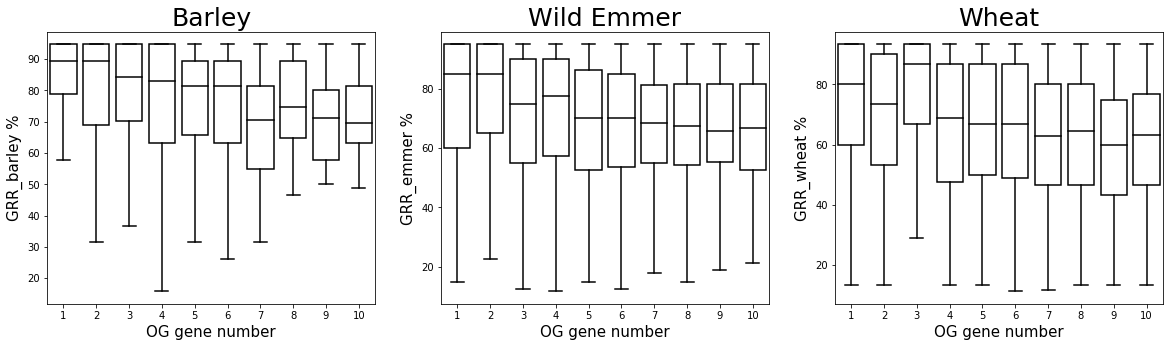

In [57]:
parameters = {'axes.labelsize': 15,
          'axes.titlesize': 25}
plt.rcParams.update(parameters)

fig,(ax1,ax2,ax3) = plt.subplots(1,3, figsize=(20, 5))
sns.boxplot(ax=ax1, x='OG_barley_gene_num', y='barley_rates', data=df_barley_tem[df_barley_tem["OG_barley_gene_num"]<11], showfliers = False)
ax1.set(title='Barley',xlabel='OG gene number', ylabel='GRR_barley %')

sns.boxplot(ax=ax2, x='OG_emmer_gene_num', y='emmer_rates', data=df_emmer_tem[df_emmer_tem["OG_emmer_gene_num"]<11], showfliers = False)
ax2.set(title='Wild Emmer', xlabel='OG gene number', ylabel='GRR_emmer %')

sns.boxplot(ax=ax3, x='OG_wheat_gene_num', y='wheat_rates', data=df_wheat_tem[df_wheat_tem["OG_wheat_gene_num"]<11], showfliers = False)
ax3.set(title='Wheat',xlabel='OG gene number', ylabel='GRR_wheat %')

plt.setp(ax1.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax1.lines, color='k')

plt.setp(ax2.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax2.lines, color='k')

plt.setp(ax3.artists, edgecolor = 'k', facecolor='w')
plt.setp(ax3.lines, color='k')


plt.show()

In [58]:
fig.savefig("/Users/yongjia/Dropbox/HPY/Submission/enrichment_plot/GRR_OG_count_v1.png", dpi=600)

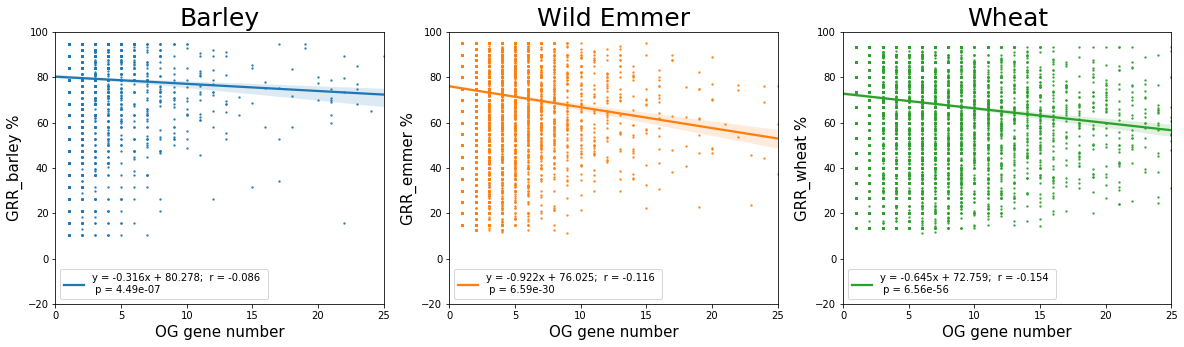

In [52]:
parameters = {'axes.labelsize': 15,
          'axes.titlesize': 25}
plt.rcParams.update(parameters)

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(df_barley_tem["OG_barley_gene_num"],df_barley_tem["barley_rates"])
sns.regplot(ax=ax1,x="OG_barley_gene_num",y="barley_rates",data=df_barley_tem, scatter_kws={'s':2},\
            line_kws={'label':"y = {0:.3f}x + {1:.3f};  r = {2:.3f} \n p = {3:.2e}".format(slope,intercept,r_value,p_value)})
#ax1.set_ylim([0.2,1.1])
ax1.legend(loc="lower left")

slope, intercept, r_value, p_value, std_err = stats.linregress(df_emmer_tem["OG_emmer_gene_num"],df_emmer_tem["emmer_rates"])
sns.regplot(ax=ax2,x="OG_emmer_gene_num",y="emmer_rates",data=df_emmer_tem, scatter_kws={'s':2},\
            line_kws={'label':"y = {0:.3f}x + {1:.3f};  r = {2:.3f} \n p = {3:.2e}".format(slope,intercept,r_value,p_value)})
ax2.legend(loc="lower left")

slope, intercept, r_value, p_value, std_err = stats.linregress(df_wheat_tem["OG_wheat_gene_num"],df_wheat_tem["wheat_rates"])
sns.regplot(ax=ax3,x="OG_wheat_gene_num",y="wheat_rates",data=df_wheat_tem, scatter_kws={'s':2},\
            line_kws={'label':"y = {0:.3f}x + {1:.3f};  r = {2:.3f} \n p = {3:.2e}".format(slope,intercept,r_value,p_value)})
ax3.legend(loc="lower left")

ax1.set(title= 'Barley', xlabel='OG gene number', ylabel='GRR_barley %')
ax2.set(title='Wild Emmer',xlabel='OG gene number', ylabel='GRR_emmer %')
ax3.set(title='Wheat',xlabel='OG gene number', ylabel='GRR_wheat %')


ax1.set(xlim=(0, 25),ylim=(-20,100))
ax2.set(xlim=(0, 25),ylim=(-20,100))
ax3.set(xlim=(0, 25),ylim=(-20,100))

plt.show()

In [53]:
fig.savefig("/Users/yongjia/Dropbox/HPY/Submission/enrichment_plot/GRR_OG_count_v3.png", dpi=600)

In [401]:
def corrfunc(x, y):
    nas = np.logical_or(x.isna(), y.isna())
    (r, p) = pearsonr(x[~nas], y[~nas])
    return r, p

In [402]:
corrfunc(df_emmer_tem["OG_emmer_gene_num"],df_emmer_tem["emmer_rates"])

(-0.11608929200916075, 6.594983069668446e-30)

In [63]:
fig.savefig("Oct20_N1_retention_rates_OG_gene_num_Brett_wheat_deletion_lowerCS.png", dpi=600)

## OctN1, Count HOG number for each OG group

In [64]:
df_OGcount = HF.groupby("OG").size().reset_index(name='OG_counts')

In [67]:
df_OGcount.head()

,OG,OG_counts
0,OG0000000,28
1,OG0000001,1
2,OG0000002,10
3,OG0000003,9
4,OG0000004,25


In [65]:
HF = HF.merge(df_OGcount,on="OG",how="left")

In [66]:
HF.head()

,HOG,OG,Gene Tree Parent Clade,Bdistachyon_pep,EM_A_pep,EM_B_pep,TaCS_A_pep_longest,TaCS_B_pep_longest,TaCS_D_pep_longest,barley,emmer,wheat,barley_rates,wheat_rates,emmer_rates,OG_counts_x,OG_counts_y
0,N1.HOG0000000,OG0000000,n27,NaN,NaN,TRIDC6BG006600.1,TraesCS6A02G038600,TraesCS6B02G053500,TraesCS2D02G316700,HORVU.MOREX.r2.6HG0453070.1,TRIDC6BG006600.1,"TraesCS6A02G038600, TraesCS6B02G053500, TraesC...",NaN,0.933333,NaN,28,28
1,N1.HOG0000001,OG0000000,n31,NaN,NaN,NaN,TraesCS6A02G038400,TraesCS6B02G053300,NaN,HORVU.MOREX.r2.6HG0453060.1,NaN,"TraesCS6A02G038400, TraesCS6B02G053300",NaN,NaN,NaN,28,28
2,N1.HOG0000002,OG0000000,n33,NaN,NaN,NaN,TraesCS7A02G158300,NaN,TraesCS6D02G044300,NaN,NaN,"TraesCS7A02G158300, TraesCS6D02G044300",NaN,NaN,NaN,28,28
3,N1.HOG0000003,OG0000000,n34,NaN,NaN,NaN,TraesCS7A02G067800,TraesCS7B02G063000,TraesCS7D02G432000,NaN,NaN,"TraesCS7A02G067800, TraesCS7B02G063000, TraesC...",NaN,NaN,NaN,28,28
4,N1.HOG0000004,OG0000000,n36,NaN,NaN,NaN,NaN,TraesCS7B02G062700,TraesCS7D02G061500,NaN,NaN,"TraesCS7B02G062700, TraesCS7D02G061500",NaN,NaN,NaN,28,28


In [68]:
HF.columns

Index(['HOG', 'OG', 'Gene Tree Parent Clade', 'Bdistachyon_pep', 'EM_A_pep',
       'EM_B_pep', 'TaCS_A_pep_longest', 'TaCS_B_pep_longest',
       'TaCS_D_pep_longest', 'barley', 'emmer', 'wheat', 'barley_rates',
       'wheat_rates', 'emmer_rates', 'OG_counts_x', 'OG_counts_y'],
      dtype='object')

In [69]:
df_barley.head()

,HOG,OG,Gene Tree Parent Clade,Bdistachyon_pep,EM_A_pep,EM_B_pep,TaCS_A_pep_longest,TaCS_B_pep_longest,TaCS_D_pep_longest,barley,emmer,wheat,barley_rates,wheat_rates,emmer_rates,OG_counts,OG_barley_gene_concat,OG_barley_gene_num
0,N1.HOG0000028,OG0000001,n0,NaN,NaN,TRIDC5BG044300.1,NaN,NaN,NaN,"HORVU.MOREX.r2.6HG0490200.1, HORVU.MOREX.r2.7H...",TRIDC5BG044300.1,NaN,0.691729,NaN,NaN,1,"HORVU.MOREX.r2.6HG0490200.1, HORVU.MOREX.r2.7H...",167
1,N1.HOG0000030,OG0000002,n6,NaN,NaN,NaN,NaN,NaN,TraesCS6D02G029800,HORVU.MOREX.r2.5HG0446590.1,NaN,TraesCS6D02G029800,0.421053,NaN,NaN,10,"HORVU.MOREX.r2.5HG0393280.1, HORVU.MOREX.r2.5H...",13
2,N1.HOG0000032,OG0000002,n10,NaN,TRIDC4AG026920.1,NaN,"TraesCS1A02G332100, TraesCS4A02G064100, TraesC...","TraesCS2B02G319900, TraesCS1B02G127100, TraesC...","TraesCS7D02G442000, TraesCS3D02G507200, TraesC...","HORVU.MOREX.r2.3HG0196890.1, HORVU.MOREX.r2.2H...",TRIDC4AG026920.1,"TraesCS1A02G332100, TraesCS4A02G064100, TraesC...",0.500000,0.590476,0.9,10,"HORVU.MOREX.r2.5HG0393280.1, HORVU.MOREX.r2.5H...",13
3,N1.HOG0000033,OG0000002,n46,NaN,NaN,NaN,NaN,"TraesCS4B02G232600, TraesCS6B02G319300",NaN,HORVU.MOREX.r2.3HG0257070.1,NaN,"TraesCS4B02G232600, TraesCS6B02G319300",0.947368,NaN,NaN,10,"HORVU.MOREX.r2.5HG0393280.1, HORVU.MOREX.r2.5H...",13
4,N1.HOG0000034,OG0000002,n50,NaN,NaN,NaN,TraesCS1A02G140000,TraesCS5B02G179400,NaN,HORVU.MOREX.r2.5HG0446830.1,NaN,"TraesCS1A02G140000, TraesCS5B02G179400",0.631579,NaN,NaN,10,"HORVU.MOREX.r2.5HG0393280.1, HORVU.MOREX.r2.5H...",13


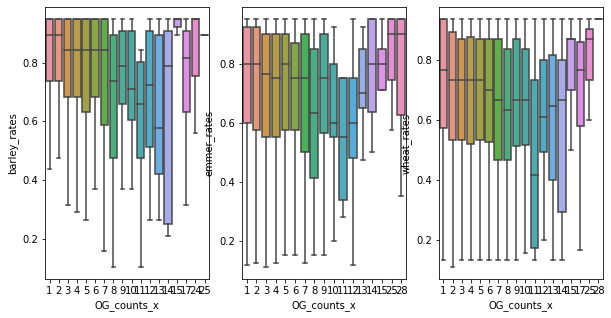

In [71]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(10,5))
sns.boxplot(ax=ax1,x="OG_counts_x",y="barley_rates",data=HF[HF.barley_rates>0.1],showfliers = False)
sns.boxplot(ax=ax2,x="OG_counts_x",y="emmer_rates",data=HF[HF.emmer_rates>0.1],showfliers = False)
sns.boxplot(ax=ax3,x="OG_counts_x",y="wheat_rates",data=HF[HF.wheat_rates>0.1],showfliers = False)

In [73]:
HF2 = HF.groupby("OG").mean()

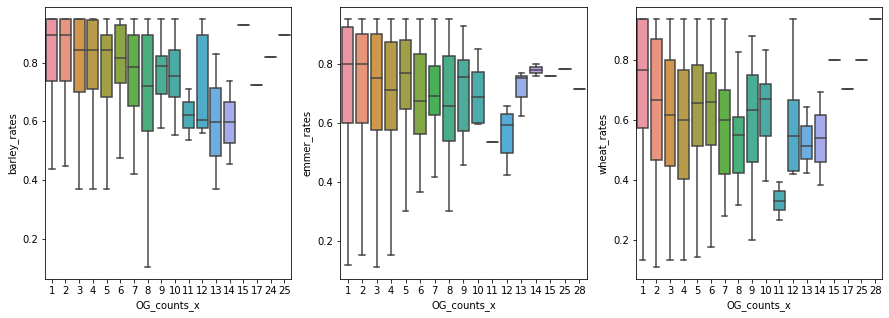

In [75]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
sns.boxplot(ax=ax1,x="OG_counts_x",y="barley_rates",data=HF2[HF2.barley_rates>0.1],showfliers = False)
sns.boxplot(ax=ax2,x="OG_counts_x",y="emmer_rates",data=HF2[HF2.emmer_rates>0.1],showfliers = False)
sns.boxplot(ax=ax3,x="OG_counts_x",y="wheat_rates",data=HF2[HF2.wheat_rates>0.1],showfliers = False)
plt.show()

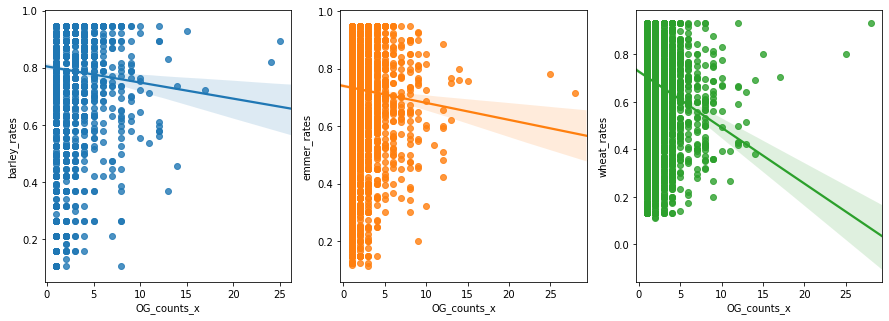

In [77]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
sns.regplot(ax=ax1,x="OG_counts_x",y="barley_rates",data=HF2[HF2.barley_rates>0.1])
sns.regplot(ax=ax2,x="OG_counts_x",y="emmer_rates",data=HF2[HF2.emmer_rates>0.1])
sns.regplot(ax=ax3,x="OG_counts_x",y="wheat_rates",data=HF2[HF2.wheat_rates>0.1])
plt.show()

In [80]:
DF1=HF2[(HF2["barley_rates"]>0.1)]
DF2=HF2[(HF2["emmer_rates"]>0.1)]
DF3=HF2[(HF2["wheat_rates"]>0.1)]

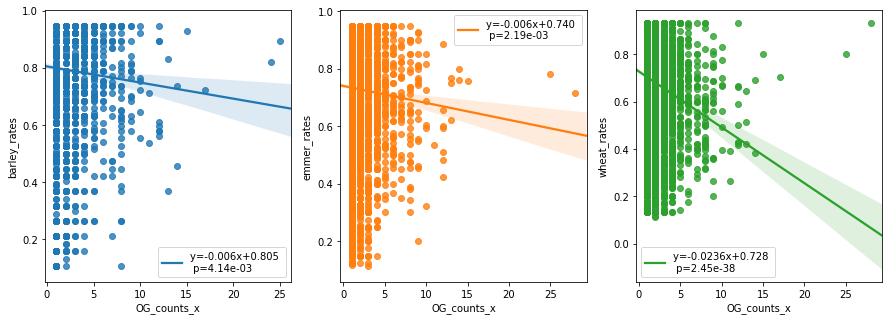

In [81]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
slope, intercept, r_value, p_value, std_err = stats.linregress(DF1["OG_counts_x"],DF1["barley_rates"])
sns.regplot(ax=ax1,x="OG_counts_x",y="barley_rates",data=DF1,\
            line_kws={'label':"y={0:.3f}x+{1:.3f} \n p={2:.2e}".format(slope,intercept, p_value)})
#ax1.set_ylim([0.2,1.1])
ax1.legend(loc="lower right")

slope, intercept, r_value, p_value, std_err = stats.linregress(DF2["OG_counts_x"],DF2["emmer_rates"])
sns.regplot(ax=ax2,x="OG_counts_x",y="emmer_rates",data=DF2,\
            line_kws={'label':"y={0:.3f}x+{1:.3f} \n p={2:.2e}".format(slope,intercept,p_value)})
ax2.legend()

slope, intercept, r_value, p_value, std_err = stats.linregress(DF3["OG_counts_x"],DF3["wheat_rates"])
sns.regplot(ax=ax3,x="OG_counts_x",y="wheat_rates",data=DF3,\
            line_kws={'label':"y={0:.4f}x+{1:.3f} \n p={2:.2e}".format(slope,intercept,p_value)})
ax3.legend()

plt.show()

In [110]:
fig.savefig("Oct20_N1_retention_rates_OG_count.png", dpi=600)

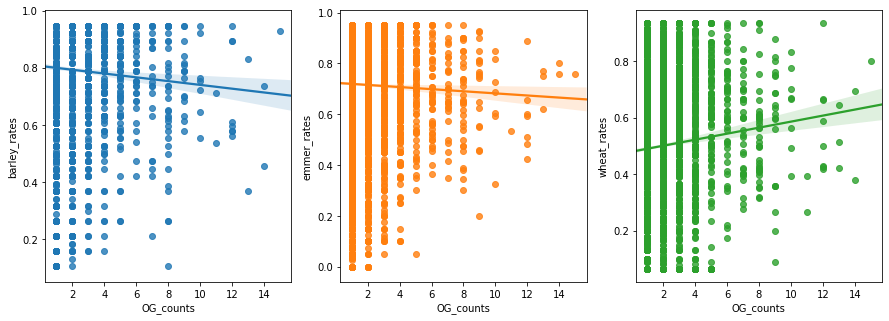

In [44]:
fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
sns.regplot(ax=ax1,x="OG_counts",y="barley_rates",data=HF_group[(HF_group["OG_counts"]<=15)])
sns.regplot(ax=ax2,x="OG_counts",y="emmer_rates",data=HF_group[(HF_group["OG_counts"]<=15)])
sns.regplot(ax=ax3,x="OG_counts",y="wheat_rates",data=HF_group[(HF_group["OG_counts"]<=15)])
plt.show()

## Old N1, Count gene number for each OG group, for three species

In [228]:
HF2 = HF[["OG","barley"]].dropna()
HF2["OG_barley_gene_concat"]=HF2.groupby("OG")["barley"].transform(lambda x: ', '.join(x))
HF2["OG_barley_gene_num"]=HF2["OG_barley_gene_concat"].str.split(expand=False).str.len()
HF2 = HF2[["OG","OG_barley_gene_concat","OG_barley_gene_num"]].drop_duplicates()

HF4 = HF[["OG","emmer"]].dropna()
HF4["OG_emmer_gene_concat"]=HF4.groupby("OG")["emmer"].transform(lambda x: ', '.join(x))
HF4["OG_emmer_gene_num"]=HF4["OG_emmer_gene_concat"].str.split(expand=False).str.len()
HF4 = HF4[["OG","OG_emmer_gene_concat","OG_emmer_gene_num"]].drop_duplicates()

HF6 = HF[["OG","wheat"]].dropna()
HF6["OG_wheat_gene_concat"]=HF6.groupby("OG")["wheat"].transform(lambda x: ', '.join(x))
HF6["OG_wheat_gene_num"]=HF6["OG_wheat_gene_concat"].str.split(expand=False).str.len()
HF6 = HF6[["OG","OG_wheat_gene_concat","OG_wheat_gene_num"]].drop_duplicates()

In [229]:
df_barley=HF[HF["barley_rates"].notnull()]
df_emmer=HF[HF["emmer_rates"].notnull()]
df_wheat=HF[HF["wheat_rates"].notnull()]

In [230]:
df_barley = df_barley.merge(HF2,on="OG",how="left")
df_emmer = df_emmer.merge(HF4,on="OG",how="left")
df_wheat = df_wheat.merge(HF6,on="OG",how="left")

In [231]:
df_barley_tem = df_barley[["OG","barley_rates","OG_barley_gene_num"]].groupby("OG").mean()
df_emmer_tem = df_emmer[["OG","emmer_rates","OG_emmer_gene_num"]].groupby("OG").mean()
df_wheat_tem = df_wheat[["OG","wheat_rates","OG_wheat_gene_num"]].groupby("OG").mean()

In [219]:
import seaborn as sns

In [287]:
bins = list(np.arange(0.5,12.5,1)) + [200] ## gene number 1-10 and rest into 11 groups
labels = np.array([str(i) for i in range(1,13)]) ## group labels
df_barley_tem["Group"] = pd.cut(df_barley_tem["OG_barley_gene_num"],bins=bins,labels=labels)
df_emmer_tem["Group"] = pd.cut(df_emmer_tem["OG_emmer_gene_num"],bins=bins,labels=labels)
df_wheat_tem["Group"] = pd.cut(df_wheat_tem["OG_wheat_gene_num"],bins=bins,labels=labels)

In [271]:
import matplotlib.pyplot as plt

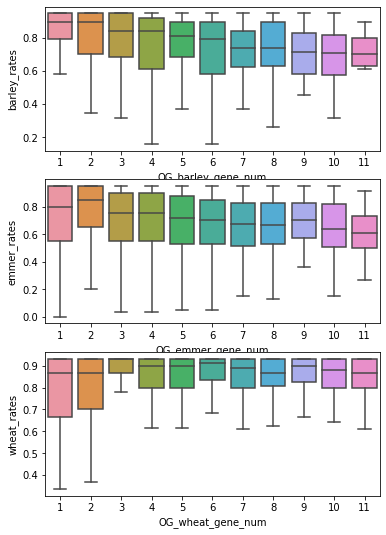

In [303]:
fig,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(6, 9))
sns.boxplot(ax=ax1, x='OG_barley_gene_num', y='barley_rates', data=df_barley_tem[df_barley_tem["OG_barley_gene_num"]<12], showfliers = False)
sns.boxplot(ax=ax2, x='OG_emmer_gene_num', y='emmer_rates', data=df_emmer_tem[df_emmer_tem["OG_emmer_gene_num"]<12], showfliers = False)
sns.boxplot(ax=ax3, x='OG_wheat_gene_num', y='wheat_rates', data=df_wheat_tem[df_wheat_tem["OG_wheat_gene_num"]<12], showfliers = False)

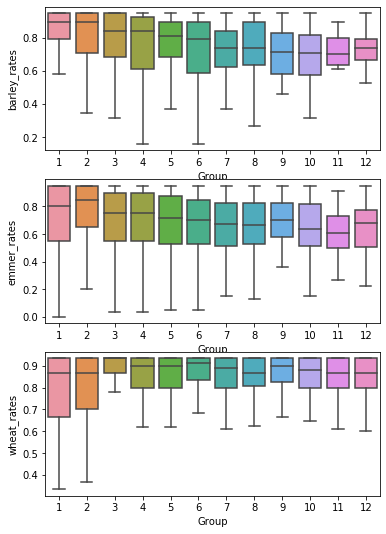

In [304]:
fig2,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(6, 9))
sns.boxplot(ax=ax1, x='Group', y='barley_rates', data=df_barley_tem, showfliers = False)
sns.boxplot(ax=ax2, x='Group', y='emmer_rates', data=df_emmer_tem, showfliers = False)
sns.boxplot(ax=ax3, x='Group', y='wheat_rates', data=df_wheat_tem, showfliers = False)

## Count gene number for each HOG group, for three species

In [294]:
HF.head()

,HOG,OG,Count,barley,emmer,wheat,barley_rates,wheat_rates,emmer_rates
0,N1.HOG0000000,OG0000000,26,HORVU.MOREX.r2.5HG0393280.1,NaN,"TraesCS6A02G324600.1.cds1, TraesCS4D02G236300....",NaN,NaN,NaN
1,N1.HOG0000001,OG0000000,26,NaN,NaN,TraesCS4B02G340800.1.cds1,NaN,NaN,NaN
2,N1.HOG0000002,OG0000000,26,NaN,NaN,TraesCS2B02G518800.1.cds1,NaN,NaN,NaN
3,N1.HOG0000003,OG0000000,26,NaN,NaN,"TraesCS7A02G331600.1.cds1, TraesCS1B02G372200....",NaN,NaN,NaN
4,N1.HOG0000004,OG0000000,26,HORVU.MOREX.r2.6HG0453380.1,NaN,TraesCS7A02G444100.1.cds1,0.947368,NaN,NaN


In [292]:
## In the above plot, OG gene number bigger than 10 displayed higher retention rates; this may be caused by multiple\
## HOGs within each OG group. To verify this, do plotting with HOG gene num

In [293]:
HOGF2 = HF[["HOG","barley"]].dropna()
HOGF2["HOG_barley_gene_concat"]=HOGF2.groupby("HOG")["barley"].transform(lambda x: ', '.join(x))
HOGF2["HOG_barley_gene_num"]=HOGF2["HOG_barley_gene_concat"].str.split(expand=False).str.len()
HOGF2 = HOGF2[["HOG","HOG_barley_gene_concat","HOG_barley_gene_num"]].drop_duplicates()

HOGF4 = HF[["HOG","emmer"]].dropna()
HOGF4["HOG_emmer_gene_concat"]=HOGF4.groupby("HOG")["emmer"].transform(lambda x: ', '.join(x))
HOGF4["HOG_emmer_gene_num"]=HOGF4["HOG_emmer_gene_concat"].str.split(expand=False).str.len()
HOGF4 = HOGF4[["HOG","HOG_emmer_gene_concat","HOG_emmer_gene_num"]].drop_duplicates()

HOGF6 = HF[["HOG","wheat"]].dropna()
HOGF6["HOG_wheat_gene_concat"]=HOGF6.groupby("HOG")["wheat"].transform(lambda x: ', '.join(x))
HOGF6["HOG_wheat_gene_num"]=HOGF6["HOG_wheat_gene_concat"].str.split(expand=False).str.len()
HOGF6 = HOGF6[["HOG","HOG_wheat_gene_concat","HOG_wheat_gene_num"]].drop_duplicates()

In [295]:
df_barley=HF[HF["barley_rates"].notnull()]
df_emmer=HF[HF["emmer_rates"].notnull()]
df_wheat=HF[HF["wheat_rates"].notnull()]

df_barley = df_barley.merge(HOGF2,on="HOG",how="left")
df_emmer = df_emmer.merge(HOGF4,on="HOG",how="left")
df_wheat = df_wheat.merge(HOGF6,on="HOG",how="left")

df_barley_hog = df_barley[["HOG","barley_rates","HOG_barley_gene_num"]].groupby("HOG").mean()
df_emmer_hog = df_emmer[["HOG","emmer_rates","HOG_emmer_gene_num"]].groupby("HOG").mean()
df_wheat_hog = df_wheat[["HOG","wheat_rates","HOG_wheat_gene_num"]].groupby("HOG").mean()

In [302]:
## save HOG gene count record to merge with kaks mean results for each HOG
df_barley_hog[["barley_rates","HOG_barley_gene_num"]].to_csv("/Volumes/Elements5T/pan_gene_count_wheatbarleyemmer/kaks_calculation/barley_HOG_count.csv")
df_emmer_hog[["emmer_rates","HOG_emmer_gene_num"]].to_csv("/Volumes/Elements5T/pan_gene_count_wheatbarleyemmer/kaks_calculation/emmer_HOG_count.csv")
df_wheat_hog[["wheat_rates","HOG_wheat_gene_num"]].to_csv("/Volumes/Elements5T/pan_gene_count_wheatbarleyemmer/kaks_calculation/wheat_HOG_count.csv")

In [296]:
bins = list(np.arange(0.5,12.5,1)) + [200] ## gene number 1-10 and rest into 11 groups
labels = np.array([str(i) for i in range(1,13)]) ## group labels
df_barley_hog["Group"] = pd.cut(df_barley_hog["HOG_barley_gene_num"],bins=bins,labels=labels)
df_emmer_hog["Group"] = pd.cut(df_emmer_hog["HOG_emmer_gene_num"],bins=bins,labels=labels)
df_wheat_hog["Group"] = pd.cut(df_wheat_hog["HOG_wheat_gene_num"],bins=bins,labels=labels)

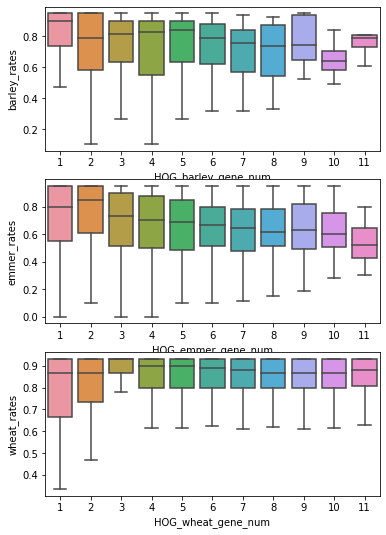

In [305]:
fig3,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(6, 9))
sns.boxplot(ax=ax1, x='HOG_barley_gene_num', y='barley_rates', data=df_barley_hog[df_barley_hog["HOG_barley_gene_num"]<12],showfliers = False)
sns.boxplot(ax=ax2, x='HOG_emmer_gene_num', y='emmer_rates', data=df_emmer_hog[df_emmer_hog["HOG_emmer_gene_num"]<12],showfliers = False)
sns.boxplot(ax=ax3, x='HOG_wheat_gene_num', y='wheat_rates', data=df_wheat_hog[df_wheat_hog["HOG_wheat_gene_num"]<12],showfliers = False)

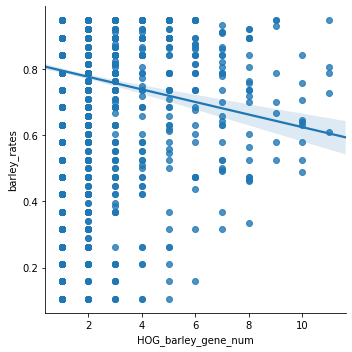

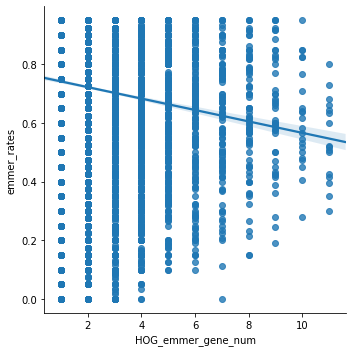

In [314]:
ax1 = sns.lmplot(x='HOG_barley_gene_num', y='barley_rates', data=df_barley_hog[df_barley_hog["HOG_barley_gene_num"]<12])
ax2=sns.lmplot(x='HOG_emmer_gene_num', y='emmer_rates', data=df_emmer_hog[df_emmer_hog["HOG_emmer_gene_num"]<12])
#ax3=sns.lmplot(x='HOG_wheat_gene_num', y='wheat_rates', data=df_wheat_hog[df_wheat_hog["HOG_wheat_gene_num"]<12])

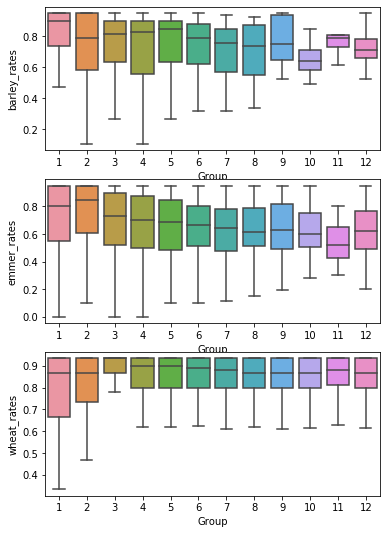

In [306]:
fig4,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(6, 9))
sns.boxplot(ax=ax1, x='Group', y='barley_rates', data=df_barley_hog,showfliers = False)
sns.boxplot(ax=ax2, x='Group', y='emmer_rates', data=df_emmer_hog,showfliers = False)
sns.boxplot(ax=ax3, x='Group', y='wheat_rates', data=df_wheat_hog,showfliers = False)

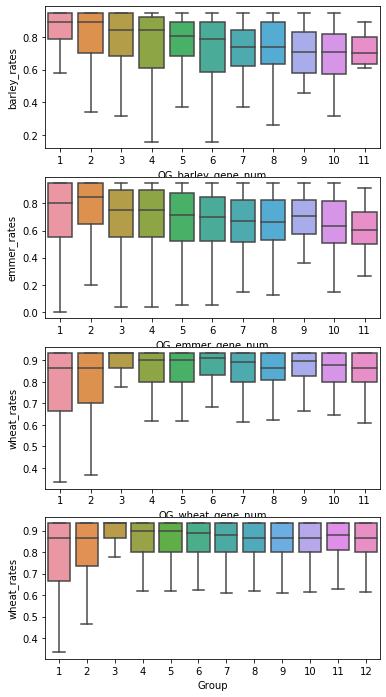

In [308]:
fig5,(ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(6, 12))
sns.boxplot(ax=ax1, x='OG_barley_gene_num', y='barley_rates', data=df_barley_tem[df_barley_tem["OG_barley_gene_num"]<12],showfliers = False)
sns.boxplot(ax=ax2, x='OG_emmer_gene_num', y='emmer_rates', data=df_emmer_tem[df_emmer_tem["OG_emmer_gene_num"]<12],showfliers = False)
sns.boxplot(ax=ax3, x='OG_wheat_gene_num', y='wheat_rates', data=df_wheat_tem[df_wheat_tem["OG_wheat_gene_num"]<12],showfliers = False)
sns.boxplot(ax=ax4, x='Group', y='wheat_rates', data=df_wheat_hog,showfliers = False)

In [309]:
fig5.savefig("Retention_rate_by_OG_num.png")

## N1 target, extract barley id for gprofiler analyses

In [165]:
#col_list = df_target["barley"].to_list()
col_list = df_target[df_target["Count"]>=2]["barley"].dropna().to_list()
gene_list=[]
for item in col_list:
    gene_list += item.split(", ")
with open("/Volumes/Elements5T/Programs/enrichment_GO/N1_target_barley_ID_OGcount_bigger2.txt","w") as f:
    for gene in gene_list:
        f.write(gene+"\n")

In [166]:
#col_list = df_target["barley"].to_list()
col_list = df_target[df_target["Count"]==1]["barley"].dropna().to_list()
gene_list=[]
for item in col_list:
    gene_list += item.split(", ")
with open("/Volumes/Elements5T/Programs/enrichment_GO/N1_target_barley_ID_OGcount_singleOG.txt","w") as f:
    for gene in gene_list:
        f.write(gene+"\n")

## N1 target, extract emmer id for direct gprofiler input analyses

In [160]:
#col_list = df_target["barley"].to_list()
col_list = df_target[df_target["Count"]>=2]["emmer"].dropna().to_list()
gene_list=[]
for item in col_list:
    gene_list += item.split(", ")
with open("/Volumes/Elements5T/Programs/enrichment_GO/N1_target_emmer_ID_OGcount_bigger2.txt","w") as f:
    for gene in gene_list:
        f.write(gene+"\n")

In [161]:
len(gene_list)

755

In [162]:
col_list = df_target[df_target["Count"]==1]["emmer"].dropna().to_list()
gene_list=[]
for item in col_list:
    gene_list += item.split(", ")
with open("/Volumes/Elements5T/Programs/enrichment_GO/N1_target_emmer_ID_OGcount_singleOG.txt","w") as f:
    for gene in gene_list:
        f.write(gene+"\n")

## N1 nontarget,  extract emmer id for direct gprofiler input analyses

In [164]:
cond1=df_barley["barley_rates"] < df_barley["emmer_rates"]
cond2=df_barley["barley_rates"] < df_barley["wheat_rates"]

df_nontarget = df_barley[np.logical_or(cond1,cond2)]

col_list = df_nontarget["emmer"].dropna().to_list()
gene_list=[]
for item in col_list:
    gene_list += item.split(", ")
with open("/Volumes/Elements5T/Programs/enrichment_GO/N1_nontarget_emmer_ID.txt","w") as f:
    for gene in gene_list:
        f.write(gene+"\n")

## N1 nontarget, extract barley id for direct gprofiler input analyses

In [167]:
cond1=df_barley["barley_rates"] < df_barley["emmer_rates"]
cond2=df_barley["barley_rates"] < df_barley["wheat_rates"]

df_nontarget = df_barley[np.logical_or(cond1,cond2)]

col_list = df_nontarget["barley"].dropna().to_list()
gene_list=[]
for item in col_list:
    gene_list += item.split(", ")
with open("/Volumes/Elements5T/Programs/enrichment_GO/N1_nontarget_barley_ID.txt","w") as f:
    for gene in gene_list:
        f.write(gene+"\n")

## N0 Rention rate calculation

In [80]:
import pandas as pd
import numpy as np

In [81]:
HOG="N0_orthogroup_count_merged_OGcount_all.csv"
barley_del="barley_sum_deletion_V2.txt"
wheat_del="wheat_deletion_updated.txt"
emmer_del="emmer_count_gene_deletion_list.txt"

## alternative retention rate calculation for wheat and barley using cd-hit results
#wheat_retention_rate="15var_wheat_db99_aS95_retention_rate.txt"
#barley_retention_rate="barleyMorexV2_19vars_protein_c99_aS95_retention_rate.txt"
emmer_retention_rate="domesticated_emmer_count_gene_deletion_list.txt"

In [82]:
HF=pd.read_csv(HOG,header=0)

In [83]:
bf=pd.read_csv(barley_del,header=None,delim_whitespace=True)
wf=pd.read_csv(wheat_del,header=None,delim_whitespace=True)
ef=pd.read_csv(emmer_retention_rate,header=None,delim_whitespace=True)

bf.set_index(0,inplace=True)
wf.set_index(0,inplace=True)
ef.set_index(0,inplace=True)

In [84]:
###barley
HOG_id_list=[]
barley_rates=[]
j=0
c=0
d=0
e=0
f=0
for index, row in HF.iterrows(): # iteritems may not consider empty value;
    j+=1
    HOG_id_list.append(str(row["barley"]).split(", "))

for item in HOG_id_list:
    ####get occurence number for each gene in present in HOG groups, put in a list: generate
    generate=[]
    if item==["nan"]:
        c+=1
    else:
        d+=1
        for i in item: # loop over barley genes
            if i in bf.index: # get pan gene occurence number, if available, some gene may not
                generate+=[int(bf.loc[i,1])]
    
    ## calculate gene retention rate for each HOG group
    if generate==[]:
        e+=1
        rate=""
    else:
        f+=1
        rate=sum([x for x in generate])/len(generate)
        rate=1-rate/19
    
    ## add rate for each HOG to list
    barley_rates.append(rate)

In [85]:
###wheat
HOG_id_list=[]
wheat_rates=[]
j=0
c=0
d=0
e=0
f=0
for index, row in HF.iterrows(): # iteritems may not consider empty value;
    j+=1
    HOG_id_list.append(str(row["wheat"]).split(", "))

for item in HOG_id_list:
    ####get occurence number for each gene in present in HOG groups, put in a list: generate
    generate=[]
    if item==["nan"]:
        c+=1
    else:
        d+=1
        for i in item: # loop over barley genes
            wid = i.split(".")[0]
            if wid in wf.index: # get pan gene occurence number, if available, some gene may not
                generate+=[int(wf.loc[wid,1])]
    
    ## calculate gene retention rate for each HOG group
    if generate==[]:
        e+=1
        rate=""
    else:
        f+=1
        rate=sum([x for x in generate])/len(generate)
        rate=1-rate/15
    
    ## add rate for each HOG to list
    wheat_rates.append(rate)

In [86]:
###emmer
HOG_id_list=[]
emmer_rates=[]
j=0
c=0
d=0
e=0
f=0
for index, row in HF.iterrows(): # iteritems may not consider empty value;
    j+=1
    HOG_id_list.append(str(row["emmer"]).split(", "))

for item in HOG_id_list:
    ####get occurence number for each gene in present in HOG groups, put in a list: generate
    generate=[]
    if item==["nan"]:
        c+=1
    else:
        d+=1
        for i in item: # loop over barley genes
            eid = i.split(".")[0]
            if eid in ef.index: # get pan gene occurence number, if available, some gene may not
                generate+=[int(ef.loc[eid,1])]
    
    ## calculate gene retention rate for each HOG group
    if generate==[]:
        e+=1
        rate=""
    else:
        f+=1
        rate=sum([x for x in generate])/len(generate)
        rate=1-rate/20
    
    ## add rate for each HOG to list
    emmer_rates.append(rate)

In [87]:
HF["barley_rates"]=barley_rates
HF["wheat_rates"]=wheat_rates
HF["emmer_rates"]=emmer_rates

In [88]:
HF.columns

Index(['HOG', 'OG', 'Count', 'Bdistachyon_pep', 'barley', 'emmer', 'wheat',
       'barley_rates', 'wheat_rates', 'emmer_rates'],
      dtype='object')

In [89]:
HF.head()

,HOG,OG,Count,Bdistachyon_pep,barley,emmer,wheat,barley_rates,wheat_rates,emmer_rates
0,N0.HOG0000000,OG0000000,4,NaN,HORVU.MOREX.r2.5HG0393280.1,NaN,"TraesCS6A02G324600.1.cds1, TraesCS4D02G236300....",,,
1,N0.HOG0000001,OG0000000,4,Bradi5g26944.2,NaN,NaN,TraesCS4B02G340800.1.cds1,,,
2,N0.HOG0000002,OG0000000,4,Bradi3g24441.1,NaN,NaN,TraesCS2B02G518800.1.cds1,,,
3,N0.HOG0000003,OG0000000,4,NaN,"HORVU.MOREX.r2.6HG0453380.1, HORVU.MOREX.r2.3H...",TRIDC4AG026920.1,"TraesCS7A02G331600.1.cds1, TraesCS7A02G444100....",0.664474,,0.9
4,N0.HOG0000004,OG0000001,12,"Bradi5g11920.5, Bradi1g49997.1","HORVU.MOREX.r2.7HG0606660.1, HORVU.MOREX.r2.2H...","TRIDC7BG009250.1, TRIDC6BG006600.1","TraesCS7A02G158300.1.cds1, TraesCS7A02G067800....",,0.933333,


In [90]:
HF = HF.replace(r'^\s*$', np.nan, regex=True)

In [91]:
HF.dtypes

HOG                 object
OG                  object
Count                int64
Bdistachyon_pep     object
barley              object
emmer               object
wheat               object
barley_rates       float64
wheat_rates        float64
emmer_rates        float64
dtype: object

In [92]:
df_barley=HF[HF["barley_rates"].notnull()]

In [93]:
df_barley.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3574 entries, 3 to 32751
Data columns (total 10 columns):
HOG                3574 non-null object
OG                 3574 non-null object
Count              3574 non-null int64
Bdistachyon_pep    2212 non-null object
barley             3574 non-null object
emmer              2680 non-null object
wheat              3197 non-null object
barley_rates       3574 non-null float64
wheat_rates        1347 non-null float64
emmer_rates        1581 non-null float64
dtypes: float64(3), int64(1), object(6)
memory usage: 307.1+ KB


In [94]:
df_barley.head()

,HOG,OG,Count,Bdistachyon_pep,barley,emmer,wheat,barley_rates,wheat_rates,emmer_rates
3,N0.HOG0000003,OG0000000,4,NaN,"HORVU.MOREX.r2.6HG0453380.1, HORVU.MOREX.r2.3H...",TRIDC4AG026920.1,"TraesCS7A02G331600.1.cds1, TraesCS7A02G444100....",0.664474,NaN,0.900000
16,N0.HOG0000016,OG0000002,1,NaN,"HORVU.MOREX.r2.7HG0584750.1, HORVU.MOREX.r2.6H...",TRIDC5BG044300.1,NaN,0.691729,NaN,NaN
26,N0.HOG0000026,OG0000004,14,Bradi4g14271.1,HORVU.MOREX.r2.5HG0421090.1,"TRIDC4AG025630.1, TRIDC5AG054270.1, TRIDC4AG01...",NaN,0.947368,NaN,0.766667
27,N0.HOG0000027,OG0000004,14,Bradi1g40350.1,"HORVU.MOREX.r2.3HG0211060.1, HORVU.MOREX.r2.4H...","TRIDC5AG048240.1, TRIDC7BG054550.1, TRIDC2BG03...",NaN,0.947368,NaN,NaN
29,N0.HOG0000029,OG0000004,14,NaN,"HORVU.MOREX.r2.2HG0153390.1, HORVU.MOREX.r2.2H...","TRIDC6AG025220.1, TRIDC5AG007870.1, TRIDC7AG03...","TraesCS5A02G050800.1, TraesCS3B02G497600.1, Tr...",0.789474,NaN,0.592857


In [95]:
cond1=df_barley["barley_rates"] > df_barley["emmer_rates"]
cond2=df_barley["barley_rates"] > df_barley["wheat_rates"]

df_target = df_barley[np.logical_or(cond1,cond2)]

In [96]:
cond3 = df_target["emmer_rates"]<df_target["wheat_rates"]
##reverse a pandas boolean series using ~
df_target=df_target[~cond3]

In [97]:
df_target.head()

,HOG,OG,Count,Bdistachyon_pep,barley,emmer,wheat,barley_rates,wheat_rates,emmer_rates
26,N0.HOG0000026,OG0000004,14,Bradi4g14271.1,HORVU.MOREX.r2.5HG0421090.1,"TRIDC4AG025630.1, TRIDC5AG054270.1, TRIDC4AG01...",NaN,0.947368,NaN,0.766667
29,N0.HOG0000029,OG0000004,14,NaN,"HORVU.MOREX.r2.2HG0153390.1, HORVU.MOREX.r2.2H...","TRIDC6AG025220.1, TRIDC5AG007870.1, TRIDC7AG03...","TraesCS5A02G050800.1, TraesCS3B02G497600.1, Tr...",0.789474,NaN,0.592857
34,N0.HOG0000034,OG0000004,14,Bradi2g27040.2,HORVU.MOREX.r2.7HG0559410.1,"TRIDC1BG005490.1, TRIDC3BG027580.1, TRIDC2BG00...",NaN,0.842105,NaN,0.775000
49,N0.HOG0000049,OG0000008,4,NaN,"HORVU.MOREX.r2.6HG0448660.1, HORVU.MOREX.r2.Un...",NaN,"TraesCS3A02G465900.1.cds1, TraesCS3A02G485800....",0.859649,0.837037,NaN
96,N0.HOG0000096,OG0000021,6,"Bradi3g49770.1, Bradi3g36780.1","HORVU.MOREX.r2.1HG0062420.1, HORVU.MOREX.r2.5H...","TRIDC1AG050290.1, TRIDC1BG057100.1, TRIDC0UG01...","TraesCS1A02G340300.1, TraesCS1B02G352600.1, Tr...",0.894737,NaN,0.650000


In [98]:
df_target.shape

(880, 10)

In [64]:
df_target["barley"].iloc[29]

'HORVU.MOREX.r2.6HG0517910.1, HORVU.MOREX.r2.6HG0517900.1'

In [67]:
#col_list = df_target["barley"].to_list()
col_list = df_target[df_target["Count"]>=2]["barley"].to_list()
gene_list=[]
for item in col_list:
    gene_list += item.split(", ")
with open("/Volumes/Elements5T/Programs/enrichment_GO/N0_target_barley_ID_OGcount_bigger2.txt","w") as f:
    for gene in gene_list:
        f.write(gene+"\n")
        

In [68]:
#col_list = df_target["Bdistachyon_pep"].dropna().to_list()
col_list = df_target[df_target["Count"]>=2]["Bdistachyon_pep"].dropna().to_list()
gene_list=[]
for item in col_list:
    gene_list += item.split(", ")
with open("/Volumes/Elements5T/Programs/enrichment_GO/N0_target_brachy_ID_OGcount_bigger2.txt","w") as f:
    for gene in gene_list:
        f.write(gene+"\n")
        

## For N0 enrichment analyses, use emmer ID for direct gprofiler inputs

In [101]:
#col_list = df_target["barley"].to_list()
col_list = df_target[df_target["Count"]>=2]["emmer"].dropna().to_list()
gene_list=[]
for item in col_list:
    gene_list += item.split(", ")
with open("/Volumes/Elements5T/Programs/enrichment_GO/N0_target_emmer_ID_OGcount_bigger2.txt","w") as f:
    for gene in gene_list:
        f.write(gene+"\n")

In [102]:
col_list = df_target[df_target["Count"]==1]["emmer"].dropna().to_list()
gene_list=[]
for item in col_list:
    gene_list += item.split(", ")
with open("/Volumes/Elements5T/Programs/enrichment_GO/N0_target_emmer_ID_OGcount_singleOG.txt","w") as f:
    for gene in gene_list:
        f.write(gene+"\n")

## calculate for N2 orthogroups

In [69]:
import pandas as pd
import numpy as np

HOG="N2_orthogroup_count_merged_OGcount_all.csv"
wheat_del="wheat_deletion_updated.txt"
emmer_del="domesticated_emmer_count_gene_deletion_list.txt"

HF=pd.read_csv(HOG,header=0)

wf=pd.read_csv(wheat_del,header=None,delim_whitespace=True)
ef=pd.read_csv(emmer_del,header=None,delim_whitespace=True)

wf.set_index(0,inplace=True)
ef.set_index(0,inplace=True)


In [70]:
###wheat
HOG_id_list=[]
wheat_rates=[]
j=0
c=0
d=0
e=0
f=0
for index, row in HF.iterrows(): # iteritems may not consider empty value;
    j+=1
    HOG_id_list.append(str(row["wheat"]).split(", "))

for item in HOG_id_list:
    ####get occurence number for each gene in present in HOG groups, put in a list: generate
    generate=[]
    if item==["nan"]:
        c+=1
    else:
        d+=1
        for i in item: # loop over barley genes
            wid = i.split(".")[0]
            if wid in wf.index: # get pan gene occurence number, if available, some gene may not
                generate+=[int(wf.loc[wid,1])]
    
    ## calculate gene retention rate for each HOG group
    if generate==[]:
        e+=1
        rate=""
    else:
        f+=1
        rate=sum([x for x in generate])/len(generate)
        rate=1-rate/15
    
    ## add rate for each HOG to list
    wheat_rates.append(rate)

In [71]:
###emmer
HOG_id_list=[]
emmer_rates=[]
j=0
c=0
d=0
e=0
f=0
for index, row in HF.iterrows(): # iteritems may not consider empty value;
    j+=1
    HOG_id_list.append(str(row["emmer"]).split(", "))

for item in HOG_id_list:
    ####get occurence number for each gene in present in HOG groups, put in a list: generate
    generate=[]
    if item==["nan"]:
        c+=1
    else:
        d+=1
        for i in item: # loop over barley genes
            eid = i.split(".")[0]
            if eid in ef.index: # get pan gene occurence number, if available, some gene may not
                generate+=[int(ef.loc[eid,1])]
    
    ## calculate gene retention rate for each HOG group
    if generate==[]:
        e+=1
        rate=""
    else:
        f+=1
        rate=sum([x for x in generate])/len(generate)
        rate=1-rate/20
    
    ## add rate for each HOG to list
    emmer_rates.append(rate)

In [72]:
HF["wheat_rates"]=wheat_rates
HF["emmer_rates"]=emmer_rates

HF = HF.replace(r'^\s*$', np.nan, regex=True)

In [75]:
HF.head(50)

,HOG,OG,Count,Bdistachyon_pep,barley,emmer,wheat,wheat_rates,emmer_rates
0,N2.HOG0000000,OG0000000,49,NaN,NaN,NaN,"TraesCS6A02G324600.1.cds1, TraesCS4D02G236300....",NaN,NaN
1,N2.HOG0000001,OG0000000,49,NaN,NaN,NaN,TraesCS4B02G340800.1.cds1,NaN,NaN
2,N2.HOG0000002,OG0000000,49,NaN,NaN,NaN,TraesCS2B02G518800.1.cds1,NaN,NaN
3,N2.HOG0000003,OG0000000,49,NaN,NaN,NaN,"TraesCS7A02G331600.1.cds1, TraesCS1B02G372200....",NaN,NaN
4,N2.HOG0000004,OG0000000,49,NaN,NaN,NaN,TraesCS7A02G444100.1.cds1,NaN,NaN
5,N2.HOG0000005,OG0000000,49,NaN,NaN,NaN,"TraesCS3A02G079700.1, TraesCS2B02G601700.1.cds...",NaN,NaN
6,N2.HOG0000006,OG0000000,49,NaN,NaN,NaN,TraesCS6D02G029800.1.cds1,NaN,NaN
7,N2.HOG0000007,OG0000000,49,NaN,NaN,NaN,"TraesCS5A02G415500.1.cds1, TraesCS1A02G219300....",NaN,NaN
8,N2.HOG0000008,OG0000000,49,NaN,NaN,NaN,"TraesCS5B02G077100.1.cds1, TraesCS4D02G252200.1",NaN,NaN
9,N2.HOG0000009,OG0000000,49,NaN,NaN,NaN,"TraesCS3B02G381200.1.cds1, TraesCS1D02G095700.1",NaN,NaN


In [76]:
HF.isna().sum()

HOG                    0
OG                     0
Count                  0
Bdistachyon_pep    42373
barley             42373
emmer              11990
wheat               3609
wheat_rates        31974
emmer_rates        30513
dtype: int64

In [77]:
cond1=HF["emmer_rates"] > HF["wheat_rates"]

HF_target = HF[cond1]
HF_target.head()

,HOG,OG,Count,Bdistachyon_pep,barley,emmer,wheat,wheat_rates,emmer_rates
269,N2.HOG0000269,OG0000010,24,NaN,NaN,TRIDC3BG002490.1,"TraesCS3B02G030000.1, TraesCSU02G203400.1, Tra...",0.766667,0.85
271,N2.HOG0000271,OG0000010,24,NaN,NaN,"TRIDC4AG047420.1, TRIDC3BG002580.1","TraesCS4A02G314200.1.cds1, TraesCS3D02G013700....",0.766667,0.95
288,N2.HOG0000288,OG0000013,17,NaN,NaN,"TRIDC1AG007580.1, TRIDC1AG007780.1, TRIDC1AG00...","TraesCS2A02G478045.1.cds1, TraesCS1B02G075000....",0.688889,0.95
291,N2.HOG0000291,OG0000013,17,NaN,NaN,"TRIDC1BG009670.1, TRIDC1BG011380.1, TRIDC1BG01...","TraesCS1A02G057400.1, TraesCS1B02G085300.1.cds...",0.866667,0.90
296,N2.HOG0000296,OG0000013,17,NaN,NaN,TRIDC1BG004200.1,TraesCS1B02G039100.1.cds1,0.933333,0.95


In [78]:
col_list = HF_target[HF_target["Count"]>=2]["emmer"].to_list()
gene_list=[]
for item in col_list:
    gene_list += item.split(", ")
with open("/Volumes/Elements5T/Programs/enrichment_GO/N2_target_emmer_ID_OGcount_bigger2.txt","w") as f:
    for gene in gene_list:
        f.write(gene+"\n")
        

In [79]:
col_list = HF_target[HF_target["Count"]==1]["emmer"].to_list()
gene_list=[]
for item in col_list:
    gene_list += item.split(", ")
with open("/Volumes/Elements5T/Programs/enrichment_GO/N2_target_emmer_ID_OGcount_singleOG.txt","w") as f:
    for gene in gene_list:
        f.write(gene+"\n")